Britton Lab - 06/09/2023 <br>

Early Polarization - Allan Deviation Plots


<font color='red'>Author: Evan McClintock

# Prep work

#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import allantools #https://allantools.readthedocs.io/en/latest/functions.html
import os
import ruptures as rpt
import scipy
import copy

plt.ioff() #https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.ioff.html
BOLD_ON = "\033[1m"
BOLD_OFF = "\033[0m"

## Functions

### **read_pax_data(filename) function: Reads in the PAX data files; outputs formatted Pandas DataFrame**

See PAX [manual](https://www.manualslib.com/manual/1634678/Thorlabs-Pax1000.html?page=39#manual) for details
- *TimeElapsed*: time elapsed [seconds]
- *s1, s2, s3*: Stokes params normalized to S0
- *S0, S1, S2, S3*: raw Stokes params [mW]
- *Azumith, Ellipticity*: Poincare sphere angles [degrees]
- *DOP*: degree of polarization [%]
- *DOCP*: degree of circular polarization [%]
- *DOLP*: degree of linear polarization [%]
- *Power_total*: total power [mW]
- *Power_pol*: polarized power [mW]
- *Power_unpol*: unpolarized power [mW]
- *Power_split_ratio*: see manual
- *Phase_difference*: see manual
- *Timestamp*: DateTime Timestamp (hh:mm:ss.µss)

### **Dataset(filename) class: Stores polarization info from run and metadata**

In [18]:
class CustomError(Exception):
    def __init__(self, message):
        super().__init__(message)
        self.message = message

In [151]:
class Dataset:
    def __init__(self, filename):
        self.title = filename[filename.rindex("PAX"):-4]
        self.filename = filename
        self.switch_param = None
        self.avg_df_arr = None
        # We store the figures before plotting since they take a while to compute
        # NCP: Non-Change-Point; CP fig: Change-Point
        # self.fig_dict['Azimuth'] =
        # NCP_fig_tup,CP_fig_tup (for az) =
        # [(need update az NCP fig?, az NCP fig), (need update az CP fig?, az CP fig)]
        self.fig_dict = {'Azimuth':[(True,None),(True,None)], 'Ellipticity':[(True,None),(True,None)]}
        
        self.plot_switch = False
        self.plot_jumps = False
        self.plot_valid = True
        self.plot_avg = False
        self.plot_param = 'Azimuth'
        
        df, num_points_dropped, device_id, serial_num, wavelength, basic_sample_rate, op_mode_period, op_mode_FFT_num = Dataset.read_pax_data(filename)
        self.device_id = device_id
        self.serial_num = serial_num
        self.wavelength = wavelength
        self.basic_sample_rate = basic_sample_rate
        self.op_mode_period = op_mode_period
        self.op_mode_FFT_num = op_mode_FFT_num
        self.num_points_dropped = num_points_dropped
        self.df = df
        self.num_points = df.shape[0]
        self.time_elapsed = df['TimeElapsed'][self.num_points-1]
        
        self.sample_rate = basic_sample_rate / (2*op_mode_period)
    
    @staticmethod
    def read_pax_data(filename):
        # read in, assign labels and variable types
        df = pd.read_csv(filepath_or_buffer=filename, delimiter=';', header=7,
                               names=['Timestamp_old', 'Time_Elapsed_old', 's1', 's2', 's3', 'S0', 'S1', 'S2', 'S3',
                                     'Azimuth', 'Ellipticity', 'DOP', 'DOCP', 'DOLP', 'Power_total', 'Power_pol', 'Power_unpol',
                                     'Power_total_dB', 'Power_pol_dB', 'Power_unpol_dB', 'Power_split_ratio',
                                     'Phase_difference', 'Warning'],
                               dtype={'Timestamp': 'string', 'Time_Elapsed': 'string', 'Warning': 'string'})

        # drop unneeded columns
        df = df.drop(columns=['Timestamp_old', 'Power_total_dB', 'Power_pol_dB', 'Power_unpol_dB', 'Warning'])

        indices_with_missing_values = df[df.isna().any(axis=1)].index # Find the indices of rows with missing values
        df = df.drop(indices_with_missing_values) # Drop rows with missing values
        dfd = df.reset_index(drop=True) # Re-index the DataFrame
        num_points_dropped = len(indices_with_missing_values)

        # format timestamp
        df['Timestamp'] = df['Time_Elapsed_old'].apply(lambda string: datetime.datetime.strptime(
            string[string.index('.') + 1:], '%H:%M:%S:%f')) #separate the 'day.' (which causes problems) and convert to datetime
        df['TimeElapsed'] = df['Timestamp'] - df['Timestamp'].iloc[0] #time elapsed since first measurement
        df['TimeElapsed'] = df['TimeElapsed'].dt.total_seconds().astype(float) #convert timedelta to float (seconds)
        df = df.drop(columns=['Time_Elapsed_old'])

        # Calculate the time difference between current and previous measurements
        df['TimeDiff'] = df['TimeElapsed'].diff()
        df.loc[0, 'TimeDiff'] = 0

        # rearrange columns
        cols = df.columns.tolist()
        cols = cols[-2:] + cols[:-2] # move TimeElapsed and TimeDiff to front
        df = df[cols]

        # Get one-off information in the header
        df_temp = pd.read_csv(filepath_or_buffer=filename, delimiter=';', header=None, usecols=[1], nrows=7)
        device_id = df_temp.iat[0,0]
        serial_num = df_temp.iat[1,0]
        wavelength = float(df_temp.iat[4,0])
        basic_sample_rate = float(df_temp.iat[5,0])
        op_mode = df_temp.iat[6,0] #operating mode string
        p_end_index = op_mode.find(' rev')
        n_start_index = op_mode.find('ent, ') + 5
        n_end_index = op_mode.find(' poi')
        op_mode_period = float(op_mode[:p_end_index]) #P part of string
        op_mode_FFT_num = int(op_mode[n_start_index:n_end_index]) #N part of string
        return df, num_points_dropped, device_id, serial_num, wavelength, basic_sample_rate, op_mode_period, op_mode_FFT_num
    
    def rate_hist(self, bins=50, xmax=None):
        timedif = self.df['TimeDiff'][1:]   # Get time diffs, excluding first entry (which is 0)
        if (xmax != None) & np.any(timedif > xmax):
            print("Warning: Data beyond xmax={:f} in {:s}".format(xmax, self.title))
        fig, ax = plt.subplots(figsize=(12,3))
        ax.hist(timedif, bins=bins, align='mid', range=(0,xmax) if xmax else None, alpha=0.75)   # plot hist; only change x range if given
        
        # Changing limits, adding titles
        if xmax != None:
            ax.set_xlim(0,xmax)
        ax.set_yscale('log')
        ax.set_xlabel('Time Difference (s)')
        ax.set_ylabel('Frequency (log scale)')
        ax.set_title('Log Histogram of Time Differences for   {:s}'.format(self.title), fontsize=12, fontweight='bold')
        ax.grid(True)
        
        # Label statistics
        ax.axvline(x=1/self.sample_rate, color='red', linestyle='--')   # Indicate nominal time dif
        timedif_avg = timedif.mean()   # Actual time dif (avg of all time diffs)
        timedif_std = timedif.std()   # STD of time diffs
        ax.axvline(x=timedif_avg, color='blue', linestyle='--')   # Indicate actual time dif
        ax.hlines(1, timedif_avg, timedif_avg+timedif_std, color='purple', lw=2)   # Indicate STD
        
        # Print statistics
        lines = [("P = {:.1f} ".format(self.op_mode_period), 'black'),
                ("N = {:d}".format(self.op_mode_FFT_num), 'black'),
                ("BSR = {:.0f} Hz".format(self.basic_sample_rate), 'black'),
                ("Sample Rate = {:.1f} Hz".format(self.sample_rate), 'black'),
                ("", 'black'),
                ("Nominal Time Diff = {:.4f} s".format(1/self.sample_rate), 'red'),
                ("Time Diff Average = {:.4f} s".format(timedif_avg), 'blue'),
                ("Time Diff STD = {:.4f} s".format(timedif_std), 'purple')]
        x_pos = 0.95
        y_pos = 0.95
        line_height = 0.08
        # WARNING: this was giving errors before, I think bc the "range=(0,xmax) if..." line earlier redefined range
        for i in range(len(lines)):
            text, color = lines[i]
            ax.text(x_pos, y_pos - i*line_height, text, color=color, horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes)
        return fig
    
    # Plots specified parameter over time
    def plot(self,sample_range=None,plot_param='Azimuth',plot_switch=False,plot_jumps=False,plot_valid=True,plot_avg=False):
        # TODO: make this into an array
        if plot_switch!=self.plot_switch:
            self.fig_dict[plot_param][1] = (True,self.fig_dict[plot_param][1][1])   # Update plot if plot_switch has changed
            self.plot_switch = plot_switch
        if plot_jumps!=self.plot_jumps:
            self.fig_dict[plot_param][1] = (True,self.fig_dict[plot_param][1][1])   # Update plot if plot_jumps has changed
            self.plot_jumps = plot_jumps
        if plot_valid!=self.plot_valid:
            self.fig_dict[plot_param][1] = (True,self.fig_dict[plot_param][1][1])   # Update plot if plot_valid has changed
            self.plot_valid = plot_valid
        if plot_avg!=self.plot_avg:
            self.fig_dict[plot_param][1] = (True,self.fig_dict[plot_param][1][1])   # Update plot if plot_avg has changed
            self.plot_avg = plot_avg
        # TODO: technically there should be a plot_~thing~ option stored for each plot_param, but I'm going with
        # just storing plot_param for now
        if plot_param!=self.plot_param:
            self.fig_dict[plot_param][1] = (True,self.fig_dict[plot_param][1][1])   # Update plot if plot_switch has changed
            self.plot_param = plot_param
        
        if self.fig_dict[plot_param][0][0]:
            print('updating NCP_fig')
            NCP_fig, NCP_ax = plt.subplots(figsize=(12,3))
            NCP_ax.plot(self.df['TimeElapsed'], self.df[plot_param], label=plot_param, linewidth=0.5, marker='o', markersize=0.8, color='red', alpha=0.5)
            NCP_ax.set_xlabel('Time [s]')
            NCP_ax.set_title('{:s} over time for   {:s}'.format(plot_param, self.title), fontsize=14, fontweight='bold')
            NCP_ax.set_ylabel('degrees')
            NCP_ax.set_title('Change in poincare angles over time')
            NCP_ax.grid(True)
            NCP_ax.legend(loc='upper right')
            self.fig_dict[plot_param][0] = (False,NCP_fig)
        
        if self.fig_dict[plot_param][1][0] & (sample_range!=None):
            print('updating CP_fig')
            CP_fig, CP_ax = plt.subplots(figsize=(12,3))
            CP_ax.plot(self.df['TimeElapsed'], self.df[plot_param], label=plot_param, linewidth=1, marker='o', markersize=1.5, color='red')
            CP_ax.set_xlabel('Time [s]')
            CP_ax.set_title('{:s} over time for   {:s}'.format(plot_param, self.title), fontsize=14, fontweight='bold')
            CP_ax.set_ylabel('degrees')
            CP_ax.set_title('Change in poincare angles over time')
            CP_ax.grid(True)
            CP_ax.legend(loc='upper right')
            # If change times have been detected, we can plot that extra information
            if (self.switch_param!=None):
                nominal_time = 1/(2*self.nominal_switch_rate)   # Time between switches

                # TODO: doing this by groupby may be more efficient/cleaner
                # If requested, overwrite the included points with the color blue
                # Assumes all valid sections start with an IsStartPoint=True and end with an IsEndPoint=True
                if plot_valid:
                    i=0
                    X = []; Y = []
                    while i < len(self.df):
                        if self.df.at[i,'IsStartPoint']:   # We reach the start of a valid section
                            while True:   # Iterate over the valid section, adding all valid points
                                X.append(self.df.at[i,'TimeElapsed'])
                                Y.append(self.df.at[i,plot_param])
                                i+=1
                                if self.df.at[i-1,'IsEndPoint']:   # If the point just added was an end point, break
                                    break
                            CP_ax.plot(X,Y, linewidth=1, marker='o', markersize=1.5, color='blue')   # Plot the valid section
                            X = []; Y = []
                        else:
                            i+=1

                # If requested, plot the estimated switches on the time series data (plot switches on entire dataset)
                if plot_switch:
                    total_switches = int(np.ceil(self.df.at[self.df.shape[0]-1, 'TimeElapsed'] / nominal_time))
                    for i in range(total_switches):
                        CP_ax.axvline(i*nominal_time + self.mean_offset, color = 'purple', linewidth=0.8)

                # If requested, plot the detected jumps that were used to determine the switch times
                if plot_jumps:
                    print('plotting jumps')
                    linestyle = '-' if self.switch_param==plot_param else '--'   # Only solid line if plotting the jumps used for change point
                    for i in range(len(self.df)):
                        if self.df.at[i,'IsJump']:
                            X = self.df.loc[i-1:i,'TimeElapsed']
                            Y = self.df.loc[i-1:i,plot_param]
                            CP_ax.plot(X,Y, linewidth=1, marker='o', markersize=1.5, linestyle=linestyle, color='orange')
                
                # If requested and if the data has been averaged, we will plot that overtop the raw data
                if (self.avg_df_arr!=None) & plot_avg:
                    avg_df_0,avg_df_2 = self.avg_df_arr
                    # TODO: plot in different colors depending on membership value; do the same above for valid points
                    plot_avg_std=False
                    plot_param_avg_str = plot_param+"Avg"
                    if plot_avg_std:
                        plot_param_std_str = plot_param+"Std"
                        CP_ax.errorbar(avg_df_0['AvgTime'],avg_df_0[plot_param_avg_str],yerr=avg_df_0[plot_param_std_str],label=plot_param+" 0",linewidth=1,marker='o',markersize=1.5,color='blue')
                        CP_ax.errorbar(avg_df_2['AvgTime'],avg_df_2[plot_param_avg_str],yerr=avg_df_2[plot_param_std_str],label=plot_param+" 2",linewidth=1,marker='o',markersize=1.5,color='blue')
                    else:
                        CP_ax.plot(avg_df_0['AvgTime'],avg_df_0[plot_param_avg_str],label=plot_param+" 0",linewidth=1,marker='o',markersize=1.5,color='blue')
                        CP_ax.plot(avg_df_2['AvgTime'],avg_df_2[plot_param_avg_str],label=plot_param+" 2",linewidth=1,marker='o',markersize=1.5,color='blue')
            
            self.fig_dict[plot_param][1] = (False,CP_fig)   # We update the change point figure tuple
        
        lines = []
        if sample_range!=None:
            for val in sample_range:
                line = self.fig_dict[plot_param][0][1].axes[0].axvline(val, color = 'green', linewidth=2)
                lines.append(line)
        display(self.fig_dict[plot_param][0][1]); plt.close(self.fig_dict[plot_param][0][1])   # Display entire plot without change points plotted
        if sample_range!=None:
            for line in lines:
                line.remove()
        if sample_range!=None:   # Display part of plot with change points plotted
            self.fig_dict[plot_param][1][1].axes[0].set_xlim(sample_range[0],sample_range[1])
            display(self.fig_dict[plot_param][1][1]); plt.close(self.fig_dict[plot_param][1][1])
    
    @staticmethod
    def compute_range(hist_df, first_tolerance, second_tolerance, patches):
        bin_start = hist_df.loc[hist_df['index'] == 0, 'bins'].iloc[0]
        bin_end = hist_df.loc[hist_df['index'] == 1, 'bins'].iloc[0]
        width = bin_end - bin_start   # width of bins
        first_tolerance_error_message = 'Likely cause: VERY high variability in dataset (how did you do this)'
        second_tolerance_error_message = 'Likely cause: FPCs moved during setup OR high variability in dataset'
        # Based on the frequencies of jump differences, approximate the range in which the peak in differences is located
        # hist_df.at[1,'log_values_diffs'] = counts of the ~0 jump differences (most adjacent points are of the same polarization)
        # hist_df.at[2,'log_values_diffs'] = counts of the next most frequent jump differences; should be the jump between polarizations
        # hist_df.at[3,'log_values_diffs'] = counts of the thirs most frequent jump differences; assuming each polarization remains constant, this should only be large if the second and third bins divide the peak in jump differences
        
        # TODO: the parameter might not have enough difference in the jumps to detect the change point
        # Temporary solution: if this is the case, throw an error to notify user. We can catch it up above
        #display(hist_df.head(10))
        if len(hist_df)<4:
            raise CustomError("Not enough differences in the jumps to detect change points")
        
        # TODO: if peak divided between two bins, simply shift number of bins and redo process to put peak into one
        if hist_df.at[3,'log_values_diffs'] < hist_df.at[2,'log_values_diffs']:   # If the O.M. diff between 2 and 3 is less than than that between 1 and 2
            #print('expected')
            # Peak of differences spans only 1 bin (expected)
            if hist_df.at[1,'log_values_diffs'] < first_tolerance:
                print(BOLD_ON + 'Error in First Tolerance: difference={:.2f} < tolerance={:.2f}'.format(hist_df.at[1,'log_values_diffs'], first_tolerance) + BOLD_OFF)
                print(BOLD_ON + first_tolerance_error_message + BOLD_OFF)
            if hist_df.at[2,'log_values_diffs'] < second_tolerance:
                print(BOLD_ON + 'Error in Second Tolerance: difference={:.2f} < tolerance={:.2f}'.format(hist_df.at[2,'log_values_diffs'], second_tolerance) + BOLD_OFF)
                print(BOLD_ON + second_tolerance_error_message + BOLD_OFF)
            left_edge = hist_df.at[1,'bins']
            right_edge = left_edge + width
            patches[hist_df.at[1,'index']].set_fc('red')   # Add highlights to jump_fig hist
        else:
            #print('rare')
            # Peak of differences spans 2 bins (rare)
            # (Assuming the data is steady so the two bins will be adjacent)
            # We increase the first tolerance and decrease the second tolerance since
            # the third bin is much larger than expected and the second bin is much smaller
            # Assume the split bins are of equal height (bin edge divides peak symmetrically)
            # Then we subtract log10(2) = 0.3 from the second tolerance and add it to the first
            if hist_df.at[1,'log_values_diffs'] < first_tolerance+0.3:
                print(BOLD_ON + 'Error in (adjusted) First Tolerance: difference={:.2f} < tolerance={:.2f}'.format(hist_df.at[1,'log_values_diffs'], first_tolerance+0.3) + BOLD_OFF)
                print(BOLD_ON + first_tolerance_error_message + BOLD_OFF)
            if hist_df.at[3,'log_values_diffs'] < second_tolerance-0.3:
                print(BOLD_ON + 'Error in (adjusted) Second Tolerance: difference={:.2f} < tolerance={:.2f}'.format(hist_df.at[3,'log_values_diffs'], second_tolerance-0.3) + BOLD_OFF)
                print(BOLD_ON + second_tolerance_error_message + BOLD_OFF)
            # Assuming the bin edge divides peak symmetrically,
            # we find that bin edge (center) which is the max of the left edges of the two split bins
            # and we take +/- half of the bin width
            center = np.maximum(hist_df.at[1,'bins'], hist_df.at[2,'bins'])
            left_edge = center - width/2
            right_edge = center + width/2
            patches[hist_df.at[1,'index']].set_fc('red')   # Add highlights to jump_fig hist
            patches[hist_df.at[2,'index']].set_fc('red')
        return left_edge, right_edge

    def change_point(self, nominal_switch_rate, change_point_range=None, n_exclude=3, degree_tolerance=3, first_tolerance=1, second_tolerance=0.5, print_process=False):
        if self.switch_param!=None:
            # TODO: allow to recalculate change points based on new change point range
            print(BOLD_ON + 'Error: change times already detected!' + BOLD_OFF)
            return
        
        # degree_tolerance: Maximum degrees we expect the azimuth or ellipticity could change per second (?)
        # first_tolerance: Order of magnitude difference between first and second bin
        # second_tolerance: Order of magnitude difference between second and third bin
        self.nominal_switch_rate = nominal_switch_rate
        # Only do change point calculations on the specified range (e.g. first 10 seconds where the signal is known to be stable)
        if change_point_range != None:
            points_skipped = self.df.index[self.df['TimeElapsed'] >= change_point_range[0]].min()
            change_point_df = self.df[(self.df['TimeElapsed'] >= change_point_range[0]) & (self.df['TimeElapsed'] <= change_point_range[1])]
            change_point_df = change_point_df.reset_index(drop=True)
        else:   # TODO: maybe do we need to deep copy self.df to change_point_df?
            points_skipped = 0
            change_point_df = self.df
        #print(points_skipped)
        #self.change_point_df = change_point_df   # Currently unused by other methods, but want to have at least the range stored
        self.change_point_range = change_point_range
        if print_process:
            # Display params we're using
            print(BOLD_ON + 'degree_tolerance = {:.1f}'.format(degree_tolerance) + BOLD_OFF)
            print(BOLD_ON + 'first_tolerance = {:.1f}'.format(first_tolerance) + BOLD_OFF)
            print(BOLD_ON + 'second_tolerance = {:.1f}\n'.format(second_tolerance) + BOLD_OFF)

        # Perform the change point process for all parameters and use the one with the largest jumps to determine
        max_jump_width = -1
        switch_param_list = ['Azimuth', 'Ellipticity']
        error_messages = []
        for switch_param_iter in switch_param_list:
            # Preprocessing
            y_iter = np.array(change_point_df[switch_param_iter].tolist())   # data we'll be using
            #display(y_iter.shape)
            
            diffs_iter = np.abs(np.array(y_iter[1:]) - np.array(y_iter[:-1]))   # Differences between data points spaced k indices apart
            #display(diffs_iter)
            #change_point_df[] = diffs_iter_temp = np.abs(change_point_df[switch_param_iter].diff())   # Differences between data points spaced k indices apart
            #display(diffs_iter.shape)
            #display(diffs_iter_temp.shape)
            
            # Visualizing the differences we're getting
            jump_fig_iter, (jump_ax1_iter, jump_ax2_iter) = plt.subplots(1,2,figsize=(12,3))
            jump_ax1_iter.plot(abs(diffs_iter))   # Plot how differences appear over time
            jump_ax1_iter.set_title('Differences between adjacent points')
            jump_ax1_iter.set_xlim(0,len(diffs_iter))
            xmax = np.max(diffs_iter)
            num_bins = int(np.ceil(xmax/(2*degree_tolerance)))   # 2*degree_tolerance = width of bins gives number of bins
            #num_bins = 100
            values_iter, bins_iter, patches_iter = jump_ax2_iter.hist(diffs_iter, bins=num_bins, range=(0, xmax))   # Plot histogram of differences
            jump_ax2_iter.set_title('Histogram of jump differences')
            jump_ax2_iter.set_yscale('log')
            jump_ax2_iter.set_xlim(0,xmax)
            jump_fig_iter.tight_layout()

            # Put the histogram data into a DataFrame
            hist_df_iter = pd.DataFrame({'bins':bins_iter[:-1],'values':values_iter})   # Return DataFrame of bin edges and values
            hist_df_iter['log_values'] = hist_df_iter['values'].replace(0,1)   # So that log doesn't throw errors. The 0/1 values won't have any effects
            hist_df_iter['log_values'] = np.log10(hist_df_iter['log_values'])   # Log scale since we're examining differences in orders of magnitude
            hist_df_iter = hist_df_iter.sort_values('log_values', ascending=False).reset_index()   # Move top bins up front
            hist_df_iter['log_values_diffs'] = np.abs(hist_df_iter['log_values'].diff())   # Take differences between order of magnitude (O.M.) measurements (these differences not equal to jump differences!)
            #display(hist_df_iter.head())

            try:
                # Computing the range which we think the proper jumps are within
                left_edge_iter, right_edge_iter = Dataset.compute_range(hist_df_iter, first_tolerance, second_tolerance, patches_iter)
                #print('Range = ({:.2f},{:.2f})'.format(left_edge_iter,right_edge_iter))
                # Add range markers to jump plot
                jump_ax1_iter.hlines(left_edge_iter, 0, len(diffs_iter), color='red', linewidth=1)
                jump_ax1_iter.hlines(right_edge_iter, 0, len(diffs_iter), color='red', linewidth=1)
                width = right_edge_iter-left_edge_iter   # Caculate width of the detected CP jump
                if print_process:
                    # If desired, we display jump_fig
                    print('jump_fig for: switch parameter = {:s}\n'.format(switch_param_iter))
                    display(jump_fig_iter); plt.close(jump_fig_iter)
                    print('\n')
            except CustomError as e:
                # If this switch_param_iter didn't work to detect CP jumps, we'll add it to the error messages
                # One parameter not working is expected;
                # If both do not work, then we have a problem: we'll print the errors then, if that happens
                err_str = "Error calculating CP jump widths in {:s}:\n\t{:s}".format(switch_param_iter,e.message)
                error_messages.append(err_str)
                width = -1
                if print_process:
                    # If desired, we'll print the error message here too, though
                    print(err_str+'\n')
            
            if width > max_jump_width:
                self.switch_param = switch_param_iter
                diffs = diffs_iter
                self.diffs = diffs_iter   # Temp
                left_edge = left_edge_iter
                right_edge = right_edge_iter
                max_jump_width = width
                jump_fig = jump_fig_iter
        
        # If neither parameter worked to detect the CP jumps, we raise an error
        if max_jump_width<0:
            err_str = ""
            for err in error_messages:
                err_str = err_str + err + '\n'
            raise CustomError(err_str + "Not enough difference in either Azimuth or Ellipticity to detect CP jumps/times")
        
        if print_process:
            # This is the parameter we're using to detect changes; the one with the larges jumps
            print(BOLD_ON + 'switch parameter = {:s}\n'.format(self.switch_param) + BOLD_OFF)
        
        # Now we have the range in which we expect the peak of differences to be (left_edge,right_edge),
        # so we search for all points where these differences developed
        # This is just for visualization purposes
        midtime_array = []
        self.df.insert(self.df.columns.get_loc('TimeDiff')+1, 'IsJump', [False]*len(self.df))
        for i in range(len(diffs)):
            dif = diffs[i]
            if (dif >= left_edge) & (dif <= right_edge):
                x1 = change_point_df.at[i,'TimeElapsed']
                x2 = change_point_df.at[i+1,'TimeElapsed']
                midtime_array.append((x1+x2)/2)
                # index needs shifting for self.df since using CP range excludes some beginning points
                # only needs shifting here because we're going off of diffs (which doesn't account for the CP range shift)
                self.df.loc[points_skipped+i+1, 'IsJump'] = True
        nominal_time = 1/(2*self.nominal_switch_rate)   # moving up here temp for print message
        if print_process:
            # If desired, print the number of jump points we detect
            CP_range_time = change_point_df.at[len(change_point_df)-1,'TimeElapsed'] - change_point_df.at[0,'TimeElapsed']
            print("Jump points detected: {:d}\nout of total: ~{:.1f}\n".format(len(midtime_array), CP_range_time/nominal_time))

        # We take the offsets (of the switch times) for all the detected jumps
        # and average them to find the best estimate for the offset
        nominal_time = 1/(2*self.nominal_switch_rate)   # Time between switches
        offset_array = np.array([time % nominal_time for time in midtime_array])   # Get offsets of each jump
        offset_array = np.array([offset if offset<nominal_time/2 else offset-nominal_time for offset in offset_array])   # Move [0,time] range to [-time/2,time/2] range (center around 0)
        mean_offset = offset_array.mean()   # This is our best estimate for the offset (from the starting time)
        if print_process:
            print("mean offset detected: {:.3f}\n".format(mean_offset))
        offset_fig,offset_ax = plt.subplots(figsize=(8,4))
        offset_ax.hist(offset_array, bins = 20)   # Plot a histogram of the offsets
        offset_ax.axvline(mean_offset, color='red', linestyle='--')
        offset_ax.grid(True)
        if print_process:
            display(offset_fig); plt.close(offset_fig)
            print('\n')
        
        # We have the estimated offset; we find the time points in the dataset that correspond to our estimated switch times
        t_min = self.df.at[0,'TimeElapsed']; t_max = self.df.at[self.df.shape[0]-1,'TimeElapsed']
        switch_array = np.arange(t_min, t_max, nominal_time) + mean_offset   # Array of estimated switch times along dataset
        switch_indices = np.searchsorted(self.df['TimeElapsed'].tolist(), switch_array)   # Time points in dataset which occur right after an estimated switch
        #value = [idx in switch_indices for idx in self.df.index]
        self.df.insert(self.df.columns.get_loc('IsJump')+1, 'IsSwitch', self.df.index.isin(switch_indices))   # These points are marked as 'True'
        
        # Now we treat these points as markers for switches between the two polarizations in our signal.
        # We exclude n points to the right&left around the switch times, as they could be outliers or limbo points.
        # The included points between each switch are valid points, and can be averaged for our recorded data.
        self.df.insert(self.df.columns.get_loc('IsSwitch')+1, 'IsValidPoint', [True]*len(self.df))   # Assume all points valid; exclude as we go
        self.df.insert(self.df.columns.get_loc('IsValidPoint')+1, 'IsStartPoint', [False]*len(self.df))
        self.df.insert(self.df.columns.get_loc('IsStartPoint')+1, 'IsEndPoint', [False]*len(self.df))
        #display(self.df[['TimeElapsed','IsJump', 'IsSwitch', 'IsValidPoint', 'Azimuth']].head(10))
        # Iterate over entire dataset; when we encounter a switch point, we'll exclude a few points around it
        for i in range(0, len(self.df)-1):
            #print('i={:d}: IsSwitch={:s}'.format(i, str(self.df.at[i, 'IsSwitch'])))
            if self.df.at[i, 'IsSwitch']:
                # We exclude n points to the left of i and n-1 points to the right of i
                # since the switch point is the point after the estimated switch time
                exclude_left_edge = i-n_exclude; exclude_right_edge = i+n_exclude-1   # Left and right edges of the exclude range
                self.df.loc[exclude_left_edge:exclude_right_edge, 'IsValidPoint'] = False   # Exclude points in range
                self.df.at[exclude_left_edge-1, 'IsEndPoint'] = True   # Mark the end of the previous valid range
                self.df.at[exclude_right_edge+1, 'IsStartPoint'] = True   # Mark the start of the next valid range
        # Also exclude the first and last few valid points which aren't complete valid segments
        first_start_ind = self.df.index[self.df['IsStartPoint']].min(); last_start_ind = self.df.index[self.df['IsStartPoint']].max()
        first_end_ind = self.df.index[self.df['IsEndPoint']].min(); last_end_ind = self.df.index[self.df['IsEndPoint']].max()
        if first_end_ind < first_start_ind:   # If first end point preceeds first start point
            self.df.at[first_end_ind,'IsEndPoint'] = False   # Get rid of first end point
            self.df.loc[0:first_end_ind, 'IsValidPoint'] = False   # Get rid of first valid points
        if last_start_ind > last_end_ind:   # If last start point succeeds last end point
            self.df.at[last_start_ind,'IsStartPoint'] = False   # Get rid of last start point
            self.df.loc[last_start_ind:len(self.df)-1, 'IsValidPoint'] = False   # Get rid of last valid points
        
        # Store the results we've found
        self.mean_offset = mean_offset
        self.left_edge = left_edge
        self.right_edge = right_edge
        
        # self.fig_dict['Azimuth'][1] is CP_fig_tup for az
        # Now that we've calculated the change times, we'll want to include that info next time we plot
        # Set all CP_fig_tup to update next time
        self.fig_dict['Azimuth'][1] = (True,self.fig_dict['Azimuth'][1][1])
        self.fig_dict['Ellipticity'][1] = (True,self.fig_dict['Ellipticity'][1][1])
        
        return jump_fig
    
    def average_data(self, average_time=None):
        if self.switch_param==None:
            print(BOLD_ON + 'Error: change times not yet detected' + BOLD_OFF)
            return
        if self.avg_df_arr!=None:
            # TODO: if change point has changed, recalculate averages
            print(BOLD_ON + 'Error: averaging already performed!' + BOLD_OFF)
            return
        
        # Create a mask for identifying contiguous sections of 'True' or 'False' values
        # 'mask' is the cumulative sum of changes in 'IsValid' values; if 'IsValid' changes value, mask will increment
        # This means every point in a 'True' or a 'False' section will have the same mask value, but mask values
        # will change between sections
        self.df['dif'] = self.df['IsValidPoint'] != self.df['IsValidPoint'].shift()
        self.df['mask'] = (self.df['dif']).cumsum()
        self.df['mask'] = self.df['mask'] - self.df.at[self.df.index[self.df['IsValidPoint']].min(),'mask']   # Ensures first True section has mask value 0
        self.df['membership'] = (self.df['mask'] % 4)   # Value of 0 for first polarization, 2 for second; switches between the two
        #display(self.df[['TimeElapsed','IsValidPoint','Azimuth','dif','mask','membership']].head(30))   # Use this line to see dif and mask in df
        
        # df[df['IsValid']] excludes all False values
        # We then group by the mask value to separate 'True' values into different sections (one group for each section)
        # groups.agg() performs aggregation functions, creating a row in avg_df for each group
        avg_df = self.df[self.df['IsValidPoint']].groupby(self.df['mask']).agg(
            StartTime=('TimeElapsed', 'first'),
            EndTime=('TimeElapsed', 'last'),
            AvgTime=('TimeElapsed', 'mean'),
            NumPoints=('TimeElapsed', 'size'),
            AzimuthAvg=('Azimuth', 'mean'),
            AzimuthStd=('Azimuth', 'std'),
            EllipticityAvg=('Ellipticity', 'mean'),
            EllipticityStd=('Ellipticity', 'std'),
            membership=('membership', 'first')   # Value of 0 or 2
        )
        avg_df.insert(avg_df.columns.get_loc('AvgTime')+1, 'Length', np.zeros(len(avg_df),dtype=float))
        avg_df['Length'] = avg_df['EndTime'] - avg_df['StartTime']
        avg_df.insert(avg_df.columns.get_loc('NumPoints')+1, 'AvgSampleRate', np.zeros(len(avg_df),dtype=float))
        avg_df['AvgSampleRate'] = avg_df['NumPoints'] / avg_df['Length']
        
        # avg_df still contains the data from both signals, alternating between the two
        # We split avg_df into two dataframes, one for each signal
        memb_grouped = avg_df.groupby('membership')   # Group by membership (signal)
        # We take deep copies of the dataframes so they aren't affected by changes in the original dataset
        memb_dataframes = {memb_group: memb_group_data.copy() for memb_group, memb_group_data in memb_grouped}
        for _, memb_df in memb_dataframes.items():
            memb_df.drop(columns='membership', inplace=True)   # Don't need this column anymore
            memb_df.reset_index(drop=True, inplace=True)
        self.avg_df_arr = [memb_dataframes[0],memb_dataframes[2]]   # Here are our two signal dataframes
        self.df.drop(columns=['dif', 'mask', 'membership'], inplace=True)   # Only drop these columns at the end 
        
        # self.fig_dict['Azimuth'][1] is CP_fig_tup for az
        # Now that we've averaged the data, we'll want to include it next time we plot
        # Set all CP_fig_tup to update next time
        self.fig_dict['Azimuth'][1] = (True,self.fig_dict['Azimuth'][1][1])
        self.fig_dict['Ellipticity'][1] = (True,self.fig_dict['Ellipticity'][1][1])
        
        return self.avg_df_arr

In [66]:
# TEMP
# Example DataFrame
data = {
    'IsValid': [True, True, True, False, False, True, True, False, True, False],
    'Time': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'Data': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
}
df = pd.DataFrame(data)

# Create a mask for identifying contiguous sections of 'True' or 'False' values
# 'mask' is the cumulative sum of changes in 'IsValid' values; if 'IsValid' changes value, mask will increment
# This means every point in a 'True' or a 'False' section will have the same mask value, but mask values
# will change between sections
df['dif'] = df['IsValid'] != df['IsValid'].shift(); df['mask'] = (df['dif']).cumsum()
df['mask'] = df['mask'] - df.at[df.index[df['IsValid']].min(),'mask']   # Ensures first True section has mask value 0
df['membership'] = (df['mask'] % 4)
display(df)   # Use this line to see dif and mask in df
# df[df['IsValid']] excludes all False values.
# We then group by the mask value to separate 'True' values into different sections (one group for each section)
# groups.agg() performs aggregation functions on each group
new_df = df[df['IsValid']].groupby(mask).agg(
    StartTime=('Time', 'first'),
    AvgData=('Data', 'mean'),
    NumPoints=('Time', 'size')
).reset_index(drop=True)
df.drop(columns=['dif', 'mask', 'membership'], inplace=True)

display(new_df)

,IsValid,Time,Data,dif,mask,membership
0,True,0,10,True,0,0
1,True,1,20,False,0,0
2,True,2,30,False,0,0
3,False,3,40,True,1,1
4,False,4,50,False,1,1
5,True,5,60,True,2,2
6,True,6,70,False,2,2
7,False,7,80,True,3,3
8,True,8,90,True,4,0
9,False,9,100,True,5,1


,StartTime,AvgData,NumPoints
0,0,10.0,1
1,1,25.0,2
2,5,65.0,2
3,8,90.0,1


updating NCP_fig
updating CP_fig


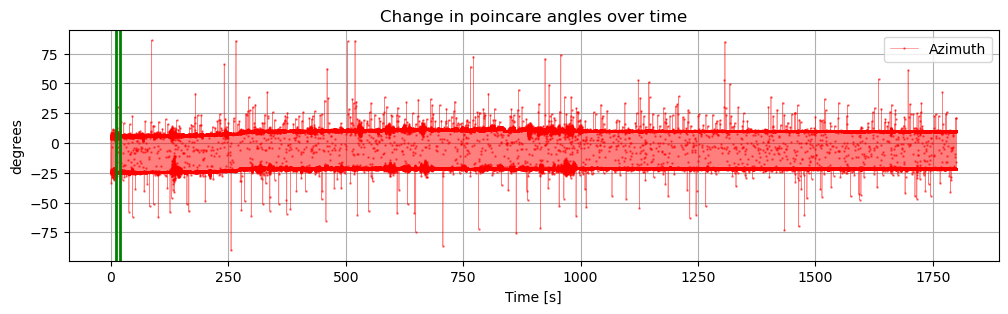

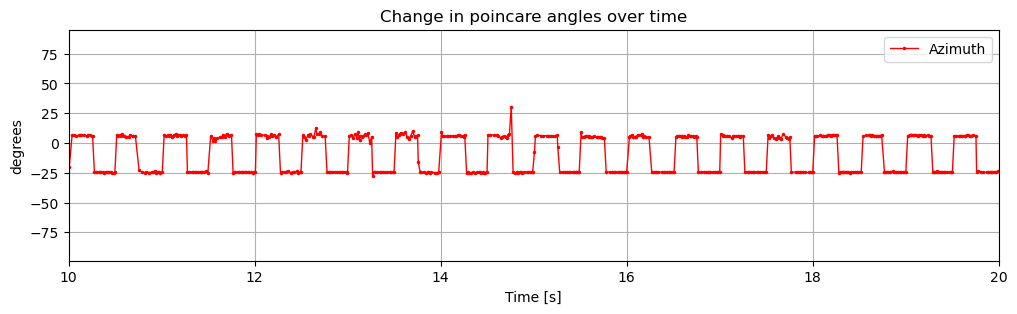

In [152]:
plt.ioff()
plt.close('all')
filename = 'Datasets/Whole_setup/PAX_1545_2Hz_DC_stability_1.csv'
#ds = datasets[0]
ds = Dataset(filename)
ds.plot(sample_range=(10,20),plot_param='Azimuth')

#### **Testing of Dataset class**

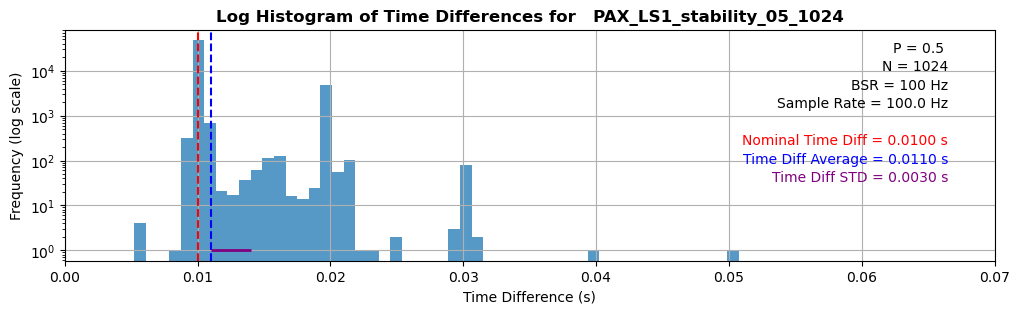

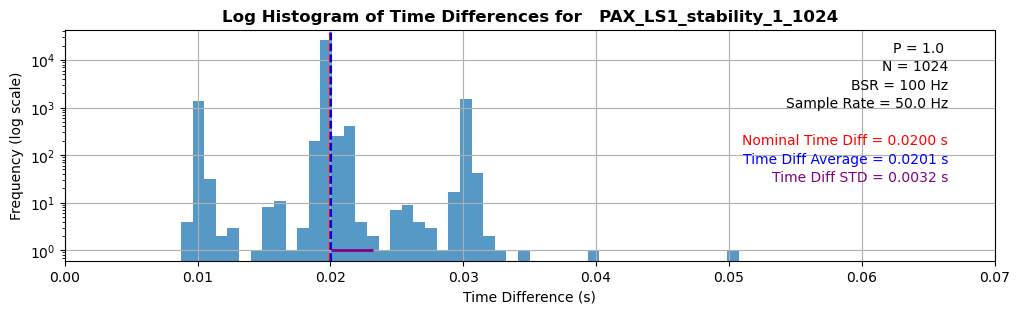

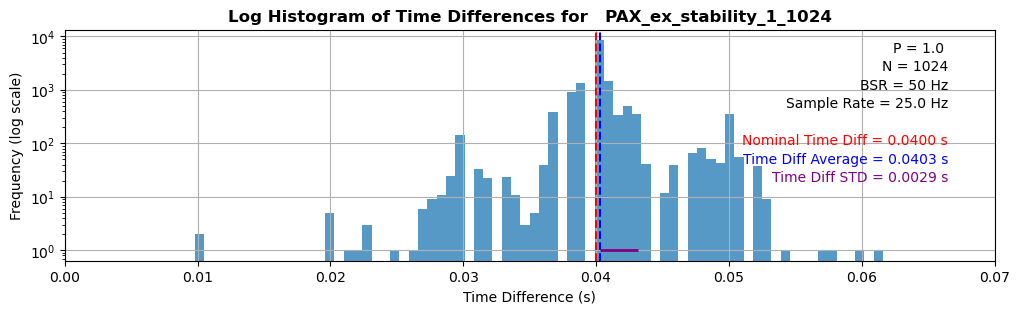

In [5]:
#Testing time diff histograms
plt.ioff()
filename_1 = "Datasets/PAX_stability/LS1_test_1/PAX_LS1_stability_05_1024.csv"
ds1 = Dataset(filename_1)
filename_2 = "Datasets/PAX_stability/LS1_test_1/PAX_LS1_stability_1_1024.csv"
ds2 = Dataset(filename_2)
filename_3 = "Datasets/PAX_stability/PAX_ex_stability_1_1024.csv"
ds3 = Dataset(filename_3)

display(ds1.rate_hist(bins=80, xmax=0.07))
display(ds2.rate_hist(bins=80, xmax=0.07))
display(ds3.rate_hist(bins=100, xmax=0.07))

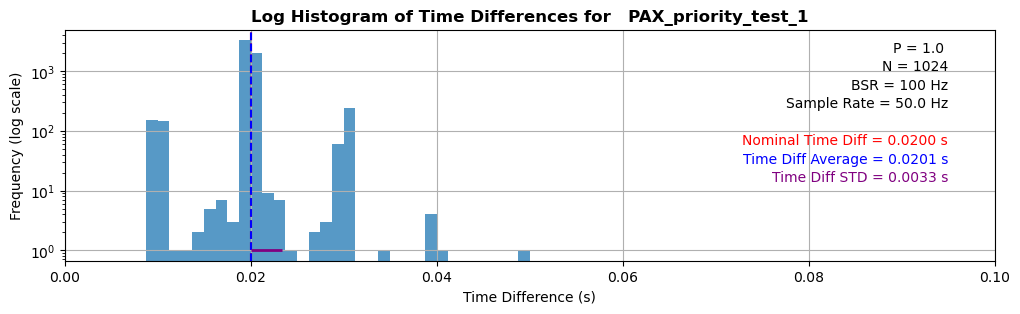

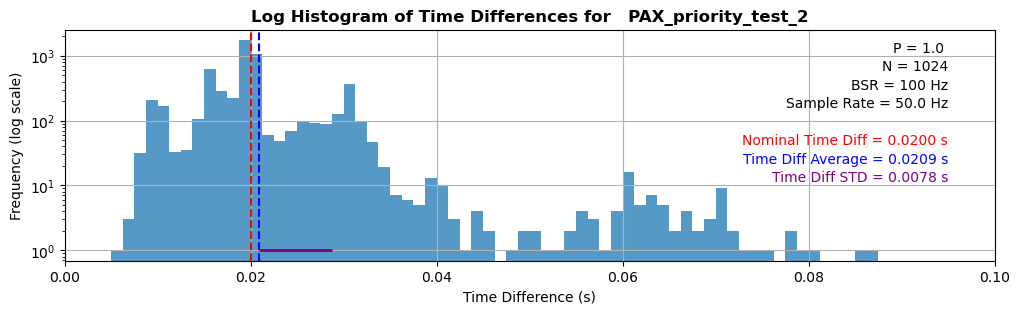

In [7]:
folder_path = 'Datasets/PAX_priority'
datasets = []
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        ds = Dataset(file_path)
        datasets.append(ds)

plt.ioff()
plt.close('all')
hist_arr = [d.rate_hist(bins=80, xmax=0.10) for d in datasets]
for f in hist_arr:
    display(f)

## Read in data

===== Datasets =====
0: PAX_1345_2Hz_DC_stability_1
1: PAX_1345_entire_30m
2: PAX_1345_entire_30m_stab_1
3: PAX_1345_fast_1
4: PAX_1345_fast_2
5: PAX_1345_initial_reading_1
6: PAX_1345_initial_reading_2
7: PAX_1345_stab_1
8: PAX_1345_stab_2
9: PAX_1545_2Hz_DC_stability_1
10: PAX_1545_stab_1
11: PAX_1545_stab_2


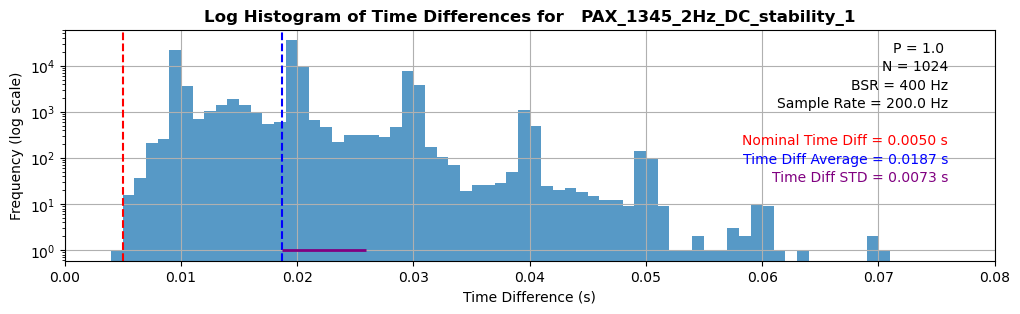

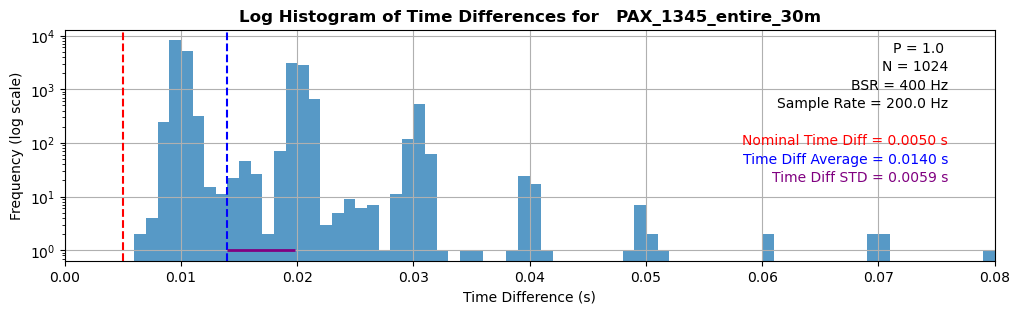

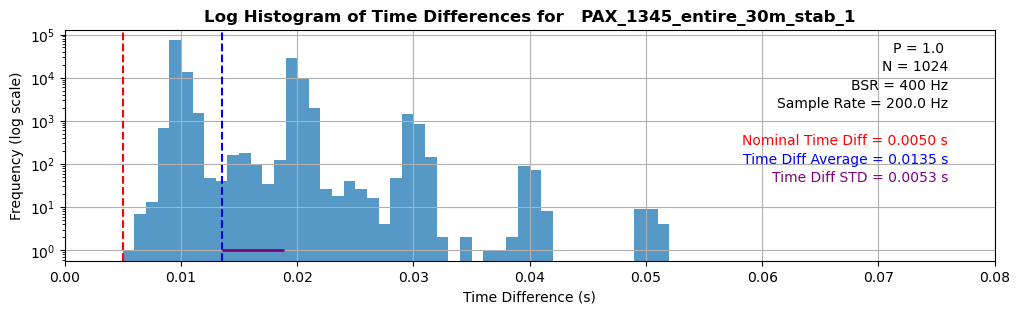

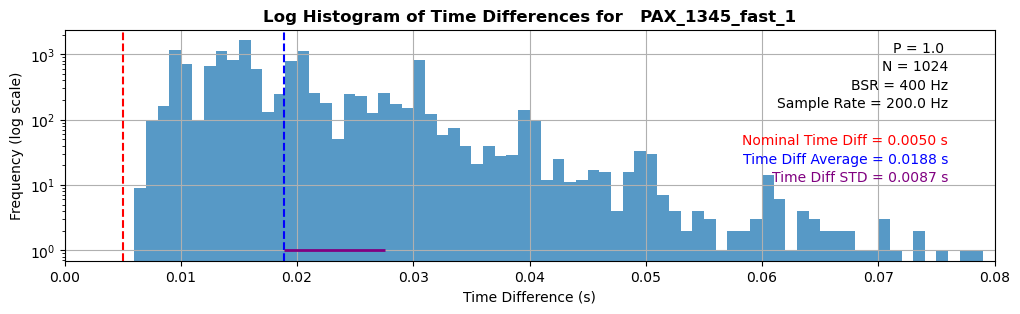

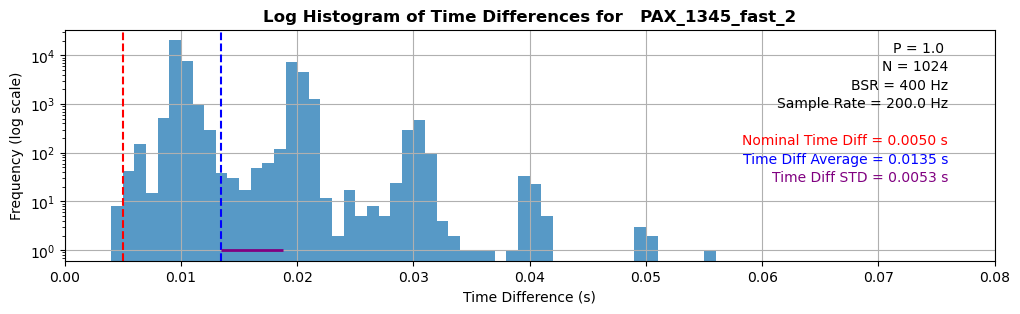

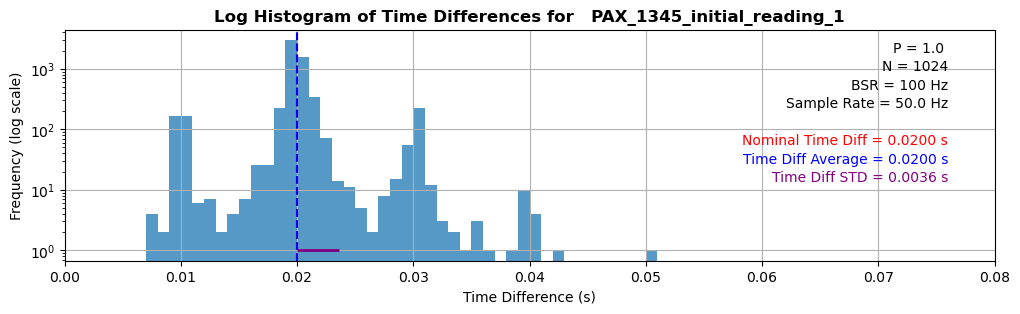

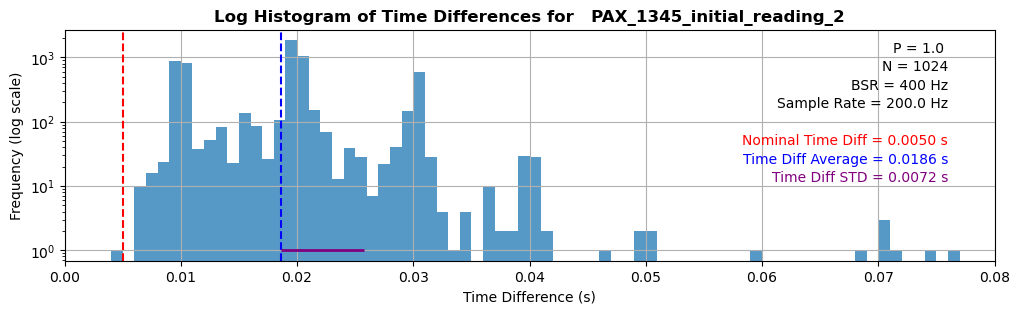

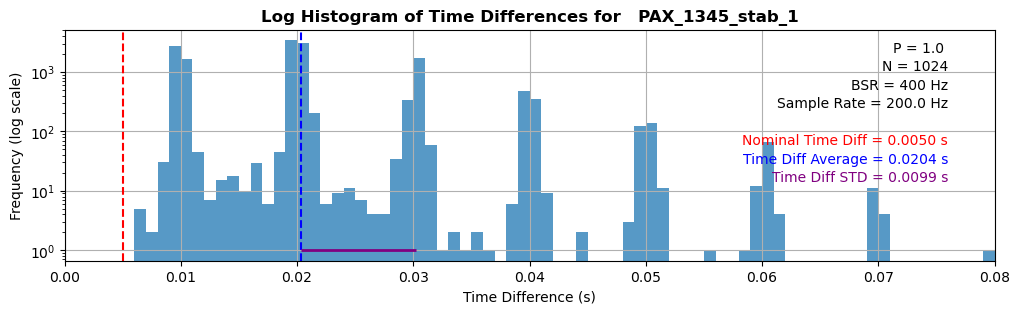

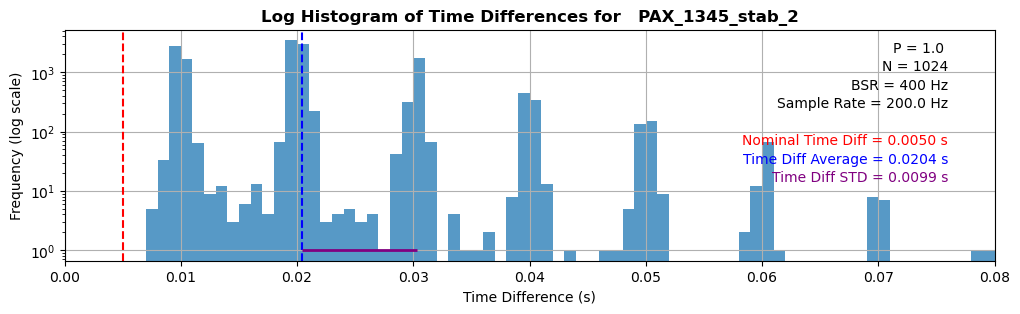

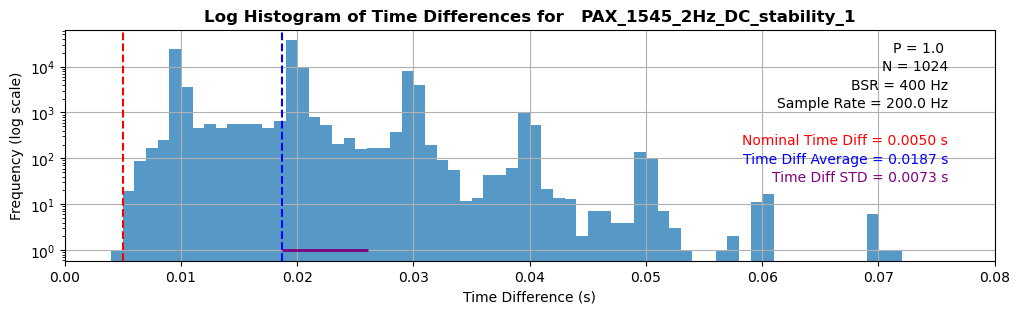

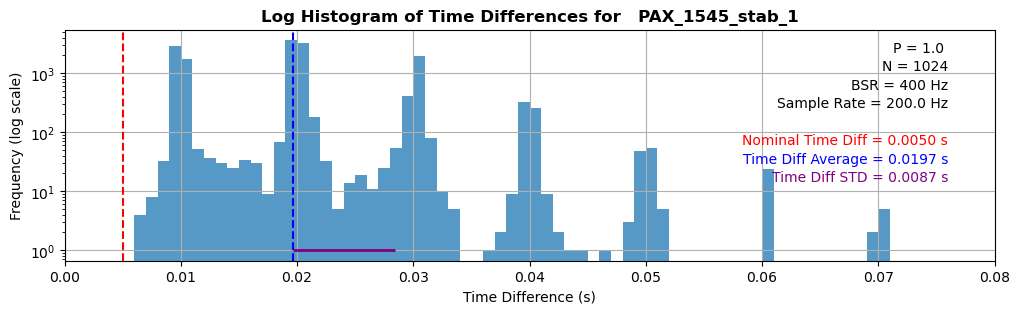

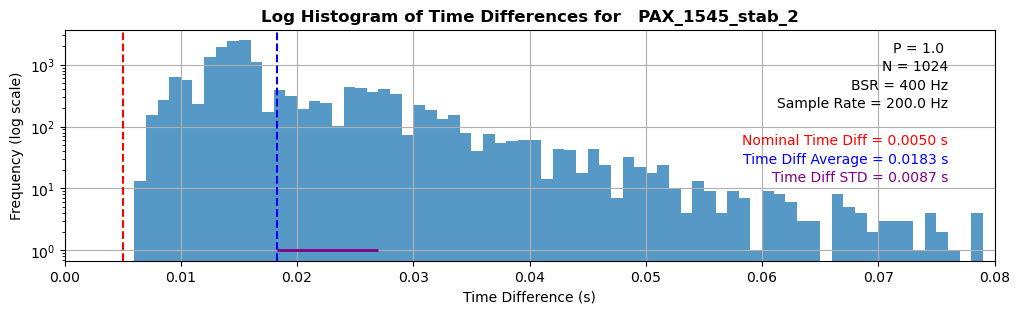

In [153]:
folder_path = 'Datasets/Whole_setup'
datasets = []
i=0
print(BOLD_ON + '===== Datasets =====' + BOLD_OFF)
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        #display(file_path)
        ds = Dataset(file_path)
        datasets.append(ds)
        print('{:d}: {:s}'.format(i, ds.title))
        i+=1
print(BOLD_ON + '========================' + BOLD_OFF)
for ds in datasets:
    rate_hist_fig = ds.rate_hist(bins=80, xmax=0.08)
    display(rate_hist_fig); plt.close(rate_hist_fig)

updating NCP_fig
updating CP_fig


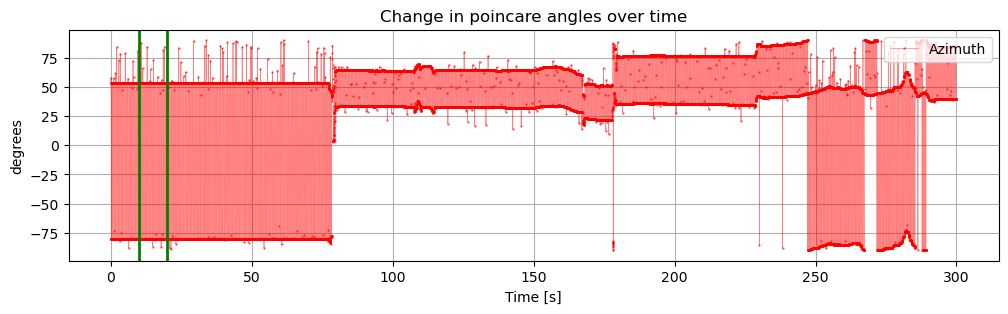

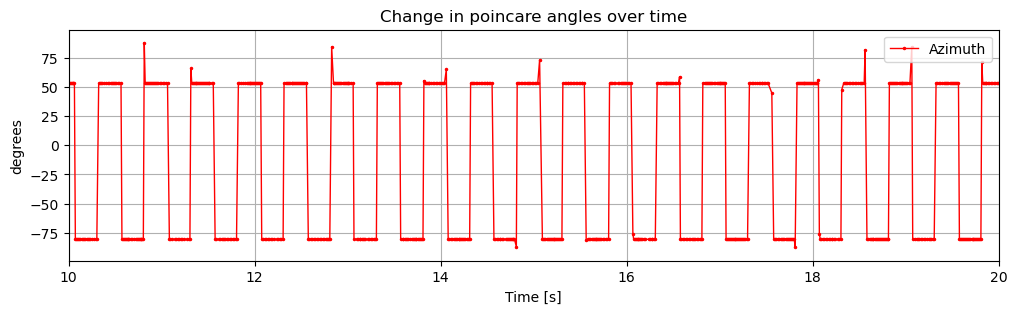

updating NCP_fig
updating CP_fig


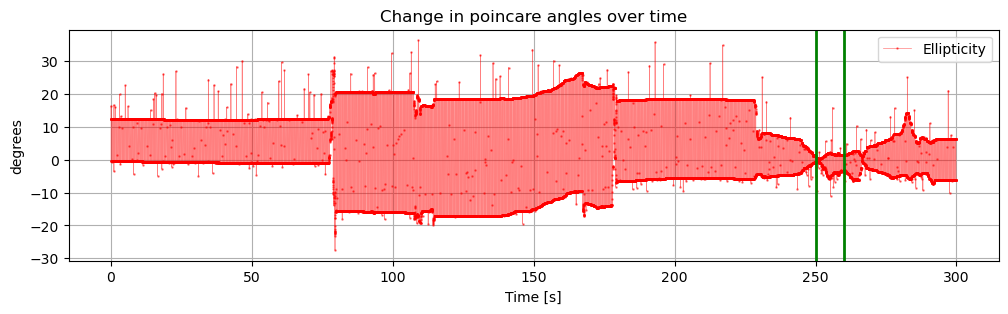

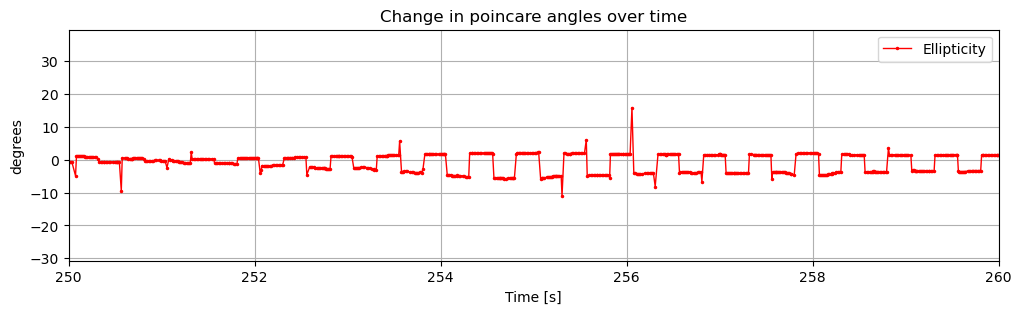

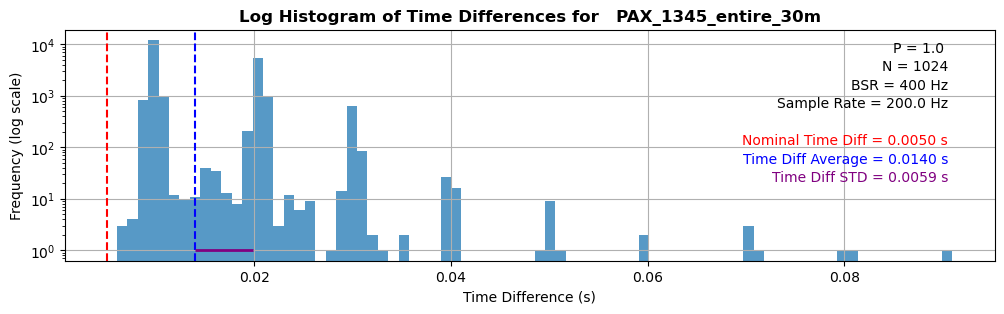

In [146]:
plt.ioff()
plt.close('all')
filename = 'Datasets/Whole_setup/PAX_1345_2Hz_DC_stability_1.csv'
filename = 'Datasets/Whole_setup/PAX_1345_entire_30m.csv'
#ds = datasets[0]
ds = Dataset(filename)
ds.plot(sample_range=(10,20),plot_param='Azimuth')
ds.plot(sample_range=(250,260),plot_param='Ellipticity')
rate_hist_fig = ds.rate_hist(bins=80)
display(rate_hist_fig); plt.close(rate_hist_fig)

degree_tolerance = 3.0
first_tolerance = 1.0
second_tolerance = 0.5

jump_fig for: switch parameter = Azimuth



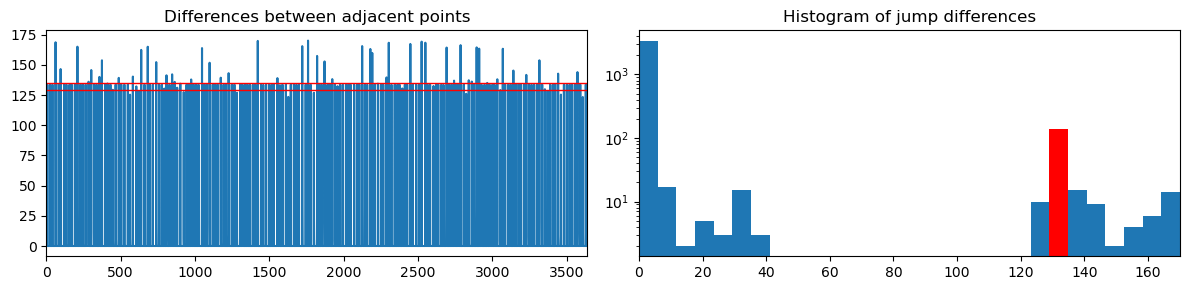



jump_fig for: switch parameter = Ellipticity



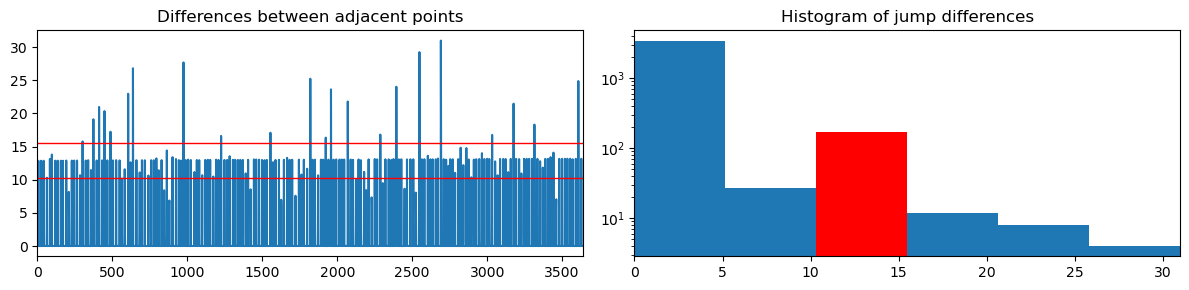



switch parameter = Azimuth

Jump points detected: 140
out of total: ~200.0

mean offset detected: 0.065



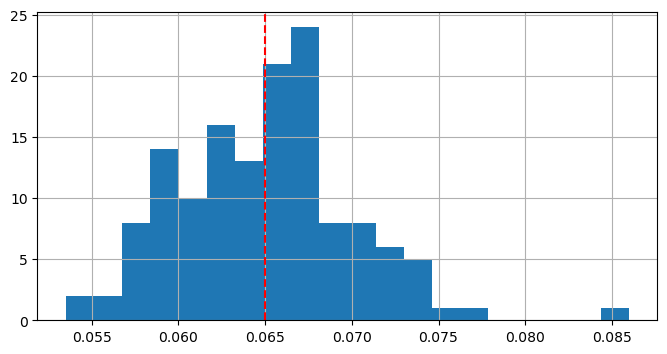

In [147]:
nominal_switch_rate = 2   # 2 Hz
change_point_range = (10,60)
ds.change_point(nominal_switch_rate, change_point_range, n_exclude=3, print_process=True)
avg_df_arr = ds.average_data()

updating CP_fig
plotting jumps


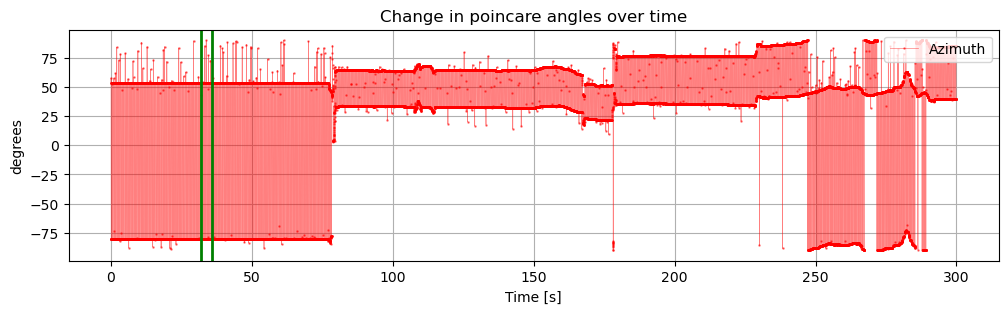

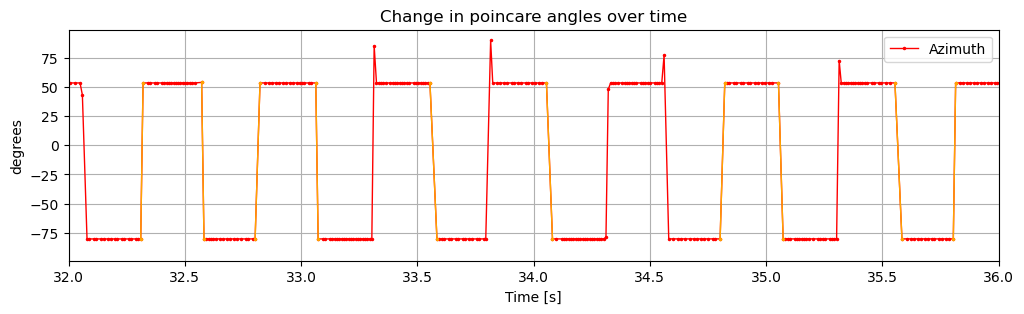

updating CP_fig


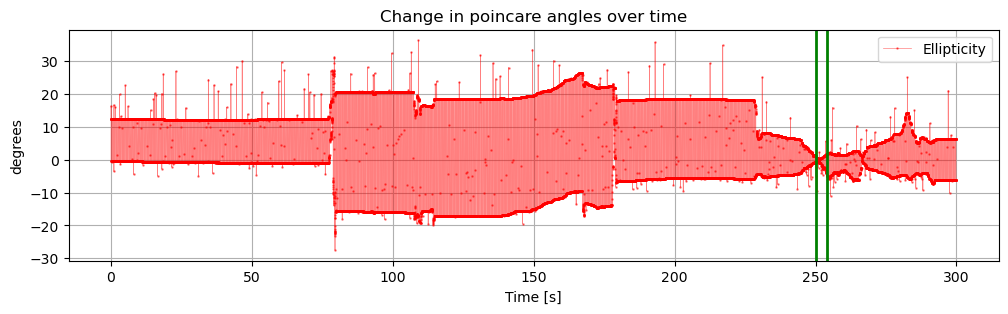

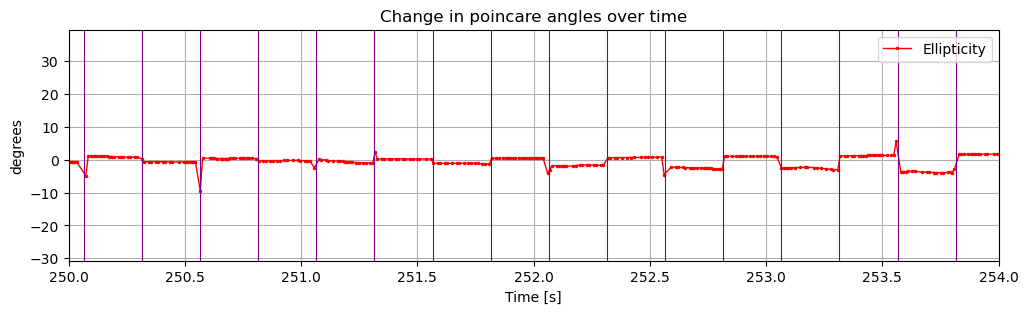

In [148]:
ds.plot(sample_range=(32,36),plot_param='Azimuth',plot_switch=False,plot_jumps=True,plot_valid=False,plot_avg=False)
ds.plot(sample_range=(250,254),plot_param='Ellipticity',plot_switch=True,plot_jumps=False,plot_valid=False,plot_avg=False)

updating CP_fig
plotting jumps


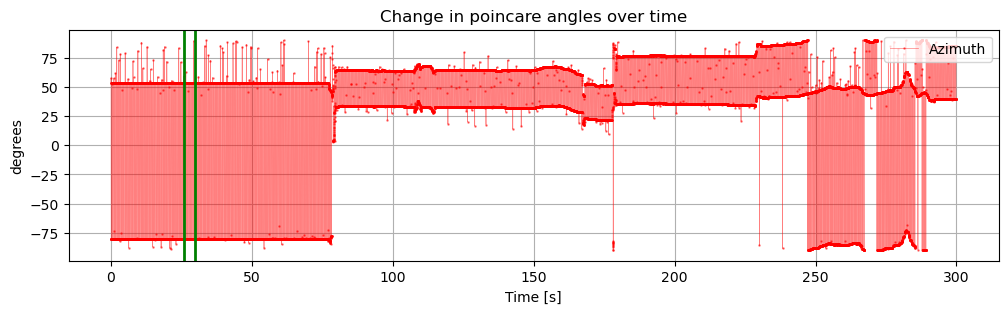

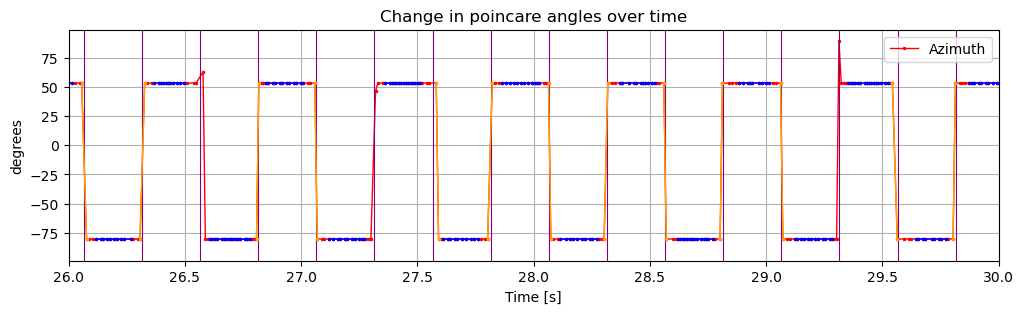

updating CP_fig


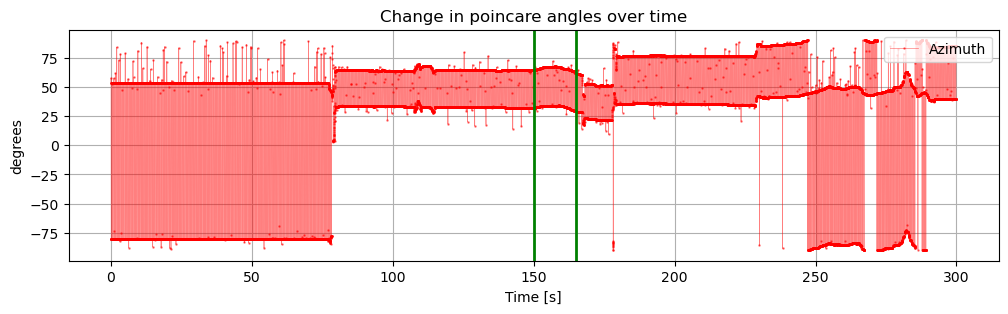

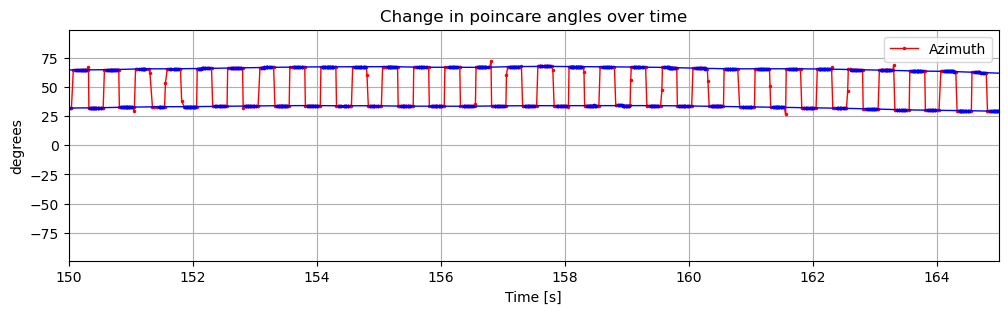

updating CP_fig


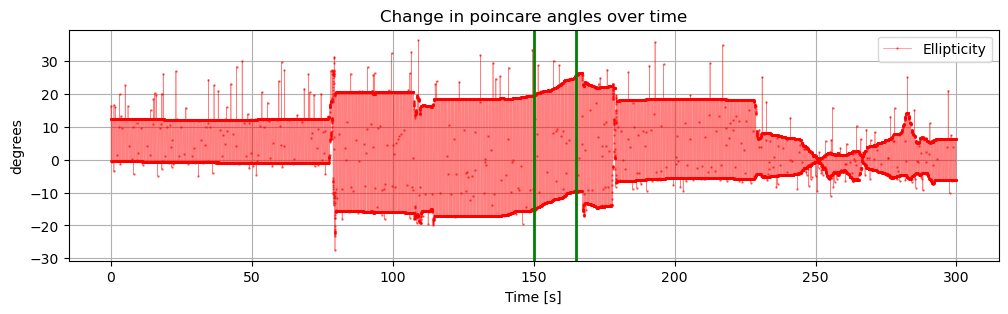

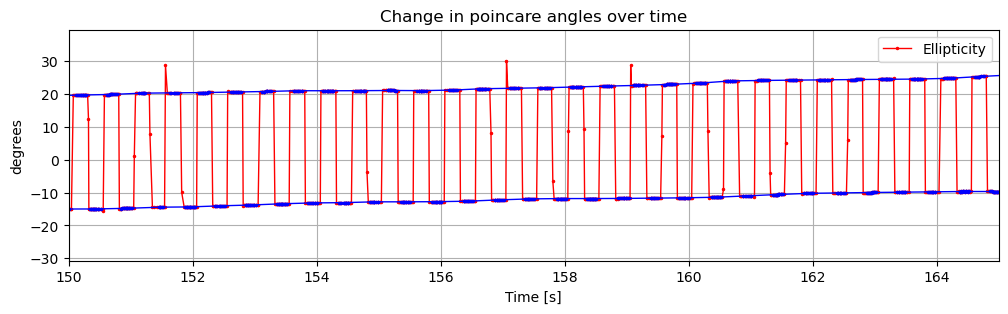

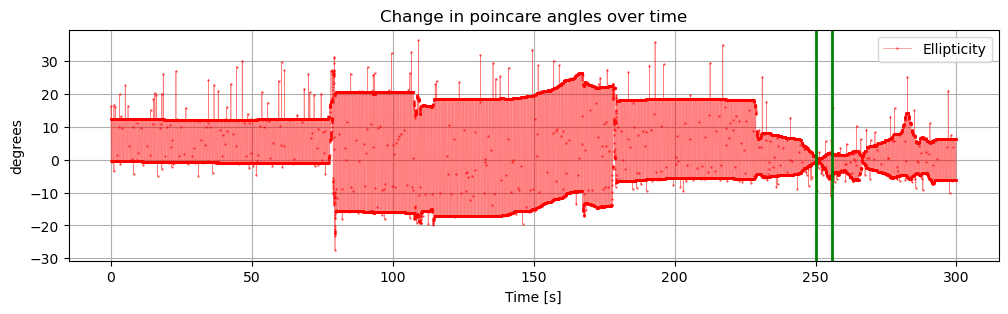

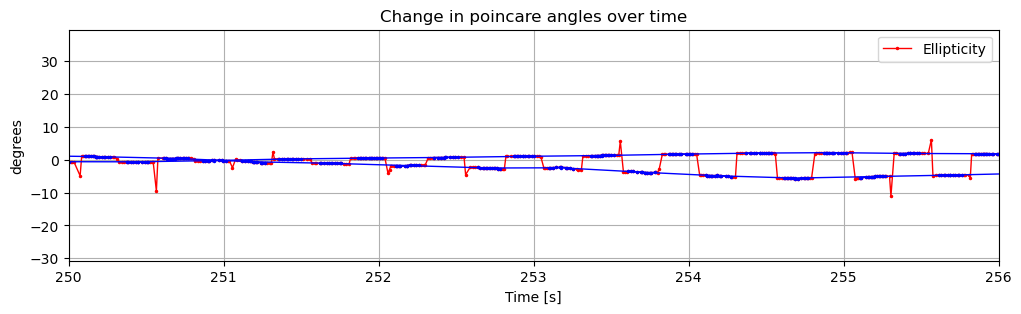

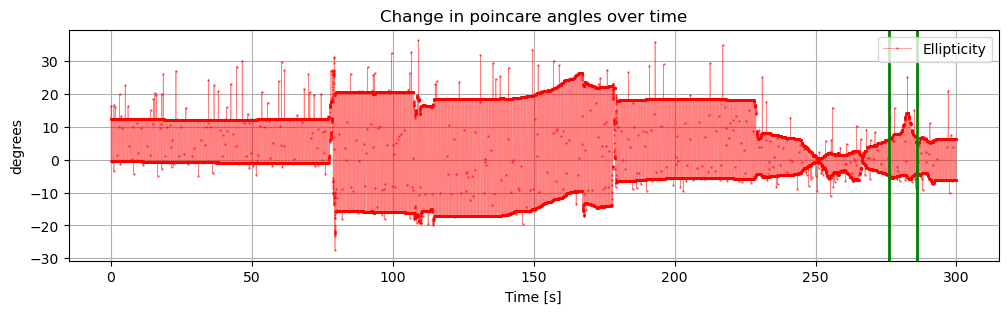

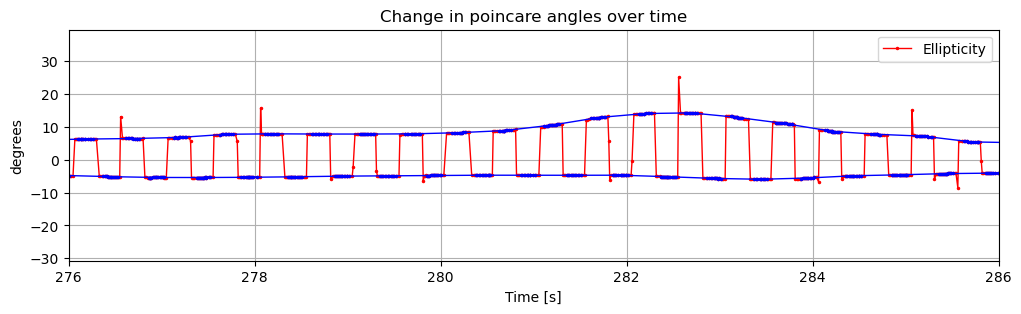

In [149]:
ds.plot(sample_range=(26,30),plot_param='Azimuth',plot_switch=True,plot_jumps=True,plot_valid=True,plot_avg=False)
ds.plot(sample_range=(150,165),plot_param='Azimuth',plot_switch=False,plot_jumps=False,plot_valid=True,plot_avg=True)
ds.plot(sample_range=(150,165),plot_param='Ellipticity',plot_switch=False,plot_jumps=False,plot_valid=True,plot_avg=True)
ds.plot(sample_range=(250,256),plot_param='Ellipticity',plot_switch=False,plot_jumps=False,plot_valid=True,plot_avg=True)
ds.plot(sample_range=(276,286),plot_param='Ellipticity',plot_switch=False,plot_jumps=False,plot_valid=True,plot_avg=True)

In [150]:
avg_df_arr[0].head(20)

,StartTime,EndTime,AvgTime,Length,NumPoints,AzimuthAvg,AzimuthStd,EllipticityAvg,EllipticityStd
0,0.121,0.231,0.175500,0.110,8,-80.670000,0.005345,12.318750,0.003536
1,0.601,0.761,0.676385,0.160,13,-80.674615,0.005189,12.325385,0.005189
2,1.111,1.282,1.196167,0.171,18,-80.679444,0.005393,12.325556,0.005113
3,1.612,1.782,1.697063,0.170,16,-80.682500,0.005774,12.332500,0.004472
4,2.104,2.264,2.178286,0.160,14,-80.686429,0.006333,12.335000,0.006504
5,2.605,2.755,2.671923,0.150,13,-80.689231,0.004935,12.330769,0.004935
6,3.106,3.256,3.171917,0.150,12,-80.688333,0.005774,12.331667,0.003892
7,3.597,3.767,3.677714,0.170,14,-80.694286,0.007559,12.340000,0.003922
8,4.098,4.269,4.178133,0.171,15,-80.695333,0.006399,12.343333,0.004880
9,4.610,4.760,4.679091,0.150,11,-80.699091,0.005394,12.349091,0.003015


updating CP_fig


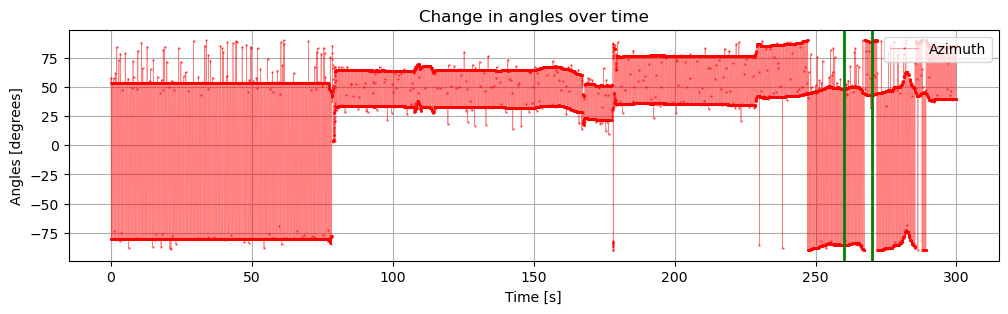

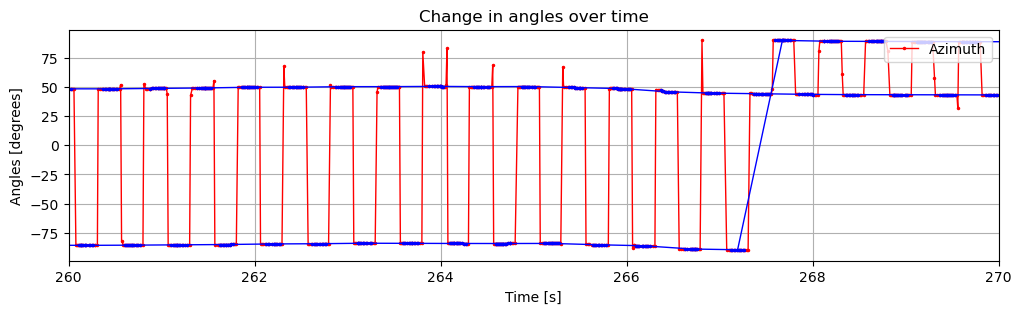

In [9]:
sample_range = (260,270)
#times = ds.df.nlargest(5, 'TimeDiff')['TimeElapsed']   # Timestamps of largest 5 time diffs
#sample_offset = times.iloc[0]-(sample_length/2)
ds.plot(sample_range=sample_range,plot_param='Azimuth',plot_switch=False,plot_jumps=False,plot_avg=True)

C:\Users\2020n\anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\2020n\anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


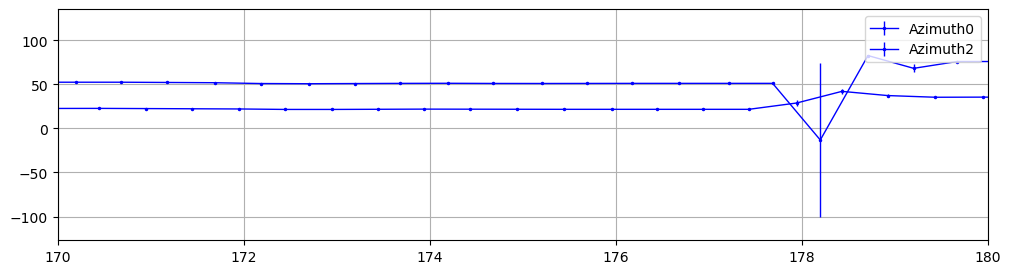

In [86]:
avg_df_0,avg_df_2 = ds.average_data()
fig, ax = plt.subplots(figsize=(12,3))
ax.errorbar(avg_df_0['AvgTime'],avg_df_0['AzimuthAvg'],yerr=avg_df_0['AzimuthStd'],label='Azimuth0',linewidth=1,marker='o',markersize=1.5,color='blue')
ax.errorbar(avg_df_2['AvgTime'],avg_df_2['AzimuthAvg'],yerr=avg_df_2['AzimuthStd'],label='Azimuth2',linewidth=1,marker='o',markersize=1.5,color='blue')
ax.grid(True)
ax.set_xlim(sample_range[0], sample_range[1])
ax.legend(loc='upper right')
display(fig); plt.close(fig)

In [6]:
df_t = ds.df[['TimeElapsed','IsJump', 'IsSwitch', 'IsValidPoint', 'IsStartPoint','IsEndPoint','Azimuth']].head(25)
#df_t.loc[8:12,'IsSwitch'] = True
#arr = df_t.loc[4:5, 'TimeElapsed'].tolist()
arr = df_t.index[df_t['IsStartPoint']].tolist()
for ind, val in enumerate(arr):
    print(ind)
    print(val)
    print('\n')
display(arr)
display(arr[0])
display(df_t)

0
8


1
22




[8, 22]

8

,TimeElapsed,IsJump,IsSwitch,IsValidPoint,IsStartPoint,IsEndPoint,Azimuth
0,0.000,False,False,False,False,False,53.01
1,0.020,False,False,False,False,False,53.01
2,0.030,False,False,False,False,False,53.02
3,0.050,False,False,False,False,False,53.01
4,0.061,False,False,False,False,False,57.72
5,0.081,False,True,False,False,False,-80.67
6,0.090,False,False,False,False,False,-80.67
7,0.111,False,False,False,False,False,-80.68
8,0.121,False,False,True,True,False,-80.67
9,0.140,False,False,True,False,False,-80.66


In [ ]:
ds.diffs.shape

=== Paradigm used for finding transition times ===


For any arbitrary signal we intend to measure, there are a few types of deviations we expect

Deviation 1: Outliers
Data points measured well above the expected maximum polarization or well below the expected minimum. So far as I've seen, these only occur at the transition times and rarely deviate more than 1 times the length of our typical jumps. These may be the result of confusion in the polarimeter as during one measurement cycle, it receives data partly from the first polarization and partly from the second. Maybe a weird behavior in the FFT?

Deviation 2: 'Limbo Points'
These are data measured in between the two expected polarizations. They separate the jump between the two, dividing the entire length of the jump into two adjacent differences. Unsure whether they occur for the same reason as outliers (confused PAX), or if maybe the PAX averages the two polarizations. Important to note that both Outliers and Limbo Points frequently appear at the same time across multiple paramters (expected).

Deviation 3: Polarization Drift
An expected deviation resulting from instability in the setup or the PTF of the fiber under test. We encode the maximum expected rate of drift in the 'degree_tolerance' parameter.

Methedology:
Since transitions occur very suddenly, we take the differences between all adjacent points and an arbitrary difference is likely to represent a transition time if it's magnitude is very large compared to the magnitude of the differences between adjacent points taken from the same signal (near 0).

Considerations:

Outliers (assuming they only occur at transition times) will increase the magnitude of the difference jump at transitions, and add another difference directly after the sharply increased first difference. We will account for this by... TODO

Limbo Points: (decreases magnitude of jumps; we will take differences between every 2 points to ensure each jump is captured. Side effect of roughly doubling number of jumps)
TODO

Polarization Drift:
TODO

degree_tolerance = 3.0
first_tolerance = 1.0
second_tolerance = 0.5
parameter = Azimuth



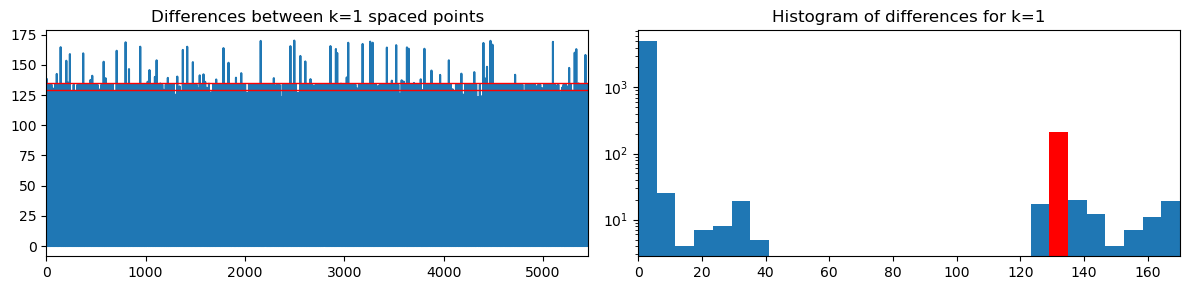

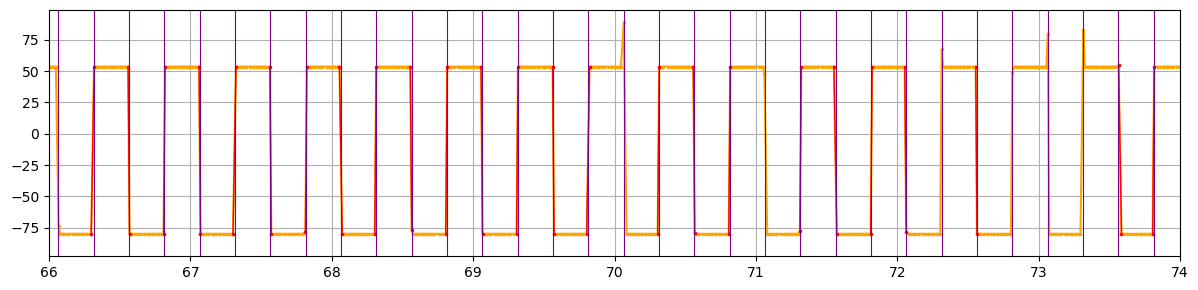

# Manual Allan Deviation

In [ ]:
# Here it is okay to use taus as a parameter, as we will recalculate the actual tau used based on meas_rate
def manual_adev(data, meas_rate, taus):
    N = data.size # number of data points present
    averages = []   # can only make list of arrays, not array of arrays (but can convert to array of arrays after)
    allan_variances = np.array([])
    taus_actual = np.array([])
    for tau in taus:
        # If tau came from simulation (where tau=num_points/meas_rate), num should be very very close to an integer
        # If tau came from us plugging in chosen values, round is probably best?
        num = round(tau*meas_rate) # number of data points corresponding to sample of length tau
        taus_actual = np.append(taus_actual, num/meas_rate)
        remainder = N%num # remaining points that are not divisible by num
        if remainder != 0:
            data_cut = data[:-remainder] #cut off remaining points to make array divisible by num
        else:
            data_cut = data #without this, data[:0] will return an empty array
        data_reshaped = data_cut.reshape(-1, num)
        data_averages = np.mean(data_reshaped, axis=1)
        averages.append(data_averages)   # again, this is the list (so use l.append(n))
        #print('For tau = {:.2f}, array size = {:.2f}'.format(tau,data_averages.size))
        #print('N = {:.2f}, num = {:.2f}, remainder = {:.2f}'.format(N, num, remainder))
        #print('Data cut size = {:.2f}'.format(data_cut.size))
        K = data_averages.size
        diffs = np.diff(data_averages)
        if K!=1:
            var = np.sum(diffs**2) / (2*(K-1))
        else:
            var=0
        allan_variances = np.append(allan_variances, var)
    averages = np.array(averages, dtype=object)   # make list of arrays into array of arrays
    return averages, allan_variances, taus_actual

In [ ]:
# Here it is okay to use taus as a parameter becuase it's just for plotting purposes; taus isn't passed along anywhere
def plot_adev(averages, allan_variances, taus):
    plt.figure(figsize=(12,5))
    for tau,avg in zip(taus,averages):
        N_avg = avg.size
        #print('For tau = {:.2f}, T = {:.2f}'.format(tau, (N_avg-1) * tau))
        times = np.linspace(0, (N_avg-1) * tau, N_avg) + tau/2
        try:
            plt.plot(times, avg, label = "tau={:.2f}s".format(tau), marker='.')
        except ValueError:
            print('Mismatch of dimensions for tau = {:.2f}'.format(tau))
            print('avg.size = {:d}'.format(N_avg))
            print('Giving np.arange(0, {:.2f}, {:.2f}) + {:.2f}/2'.format(N_avg*tau, tau, tau))
            print('so times.size = {:d}'.format(times.size))
    T = (averages[0].size-1) * taus[0]
    #print(averages[0])
    #print(taus[0])
    #print('For first entry, T = {:.2f}'.format(T))
    plt.xlim(0,T)
    plt.xlabel("Time [s]")
    plt.ylabel("Value")
    plt.title("Data averaged over different times")
    plt.grid(True)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=7)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12,3))
    plt.plot(taus, allan_variances, marker='o')
    plt.xlabel("Averaging Time")
    plt.ylabel("Variance")
    plt.xscale("log")
    plt.yscale("log")
    plt.title("Variance vs averaging time")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return

# Noise Simulation

## Simulation Functions

In [ ]:
# TODO: refer to paper for more definitive way to define noise spectrums
# params most commonly used by engineers to characterize noise
def generate_white_noise(N, meas_rate, seed=None):
    if seed != None:
        np.random.seed(seed+1) # seed for white noise
    
    white_noise = np.random.normal(0., 1., N) #N normally distributed points
    # As meas_rate increases, the noise on each individual measurement should decrease since we're measuring
    # more times in a single second (taking multiple measurements for (theoretically the same amount of noise)
    # But as T increases, the noise in each measurement shouldn't change, since we're just measuring for longer
    norm_const = np.sqrt(1/meas_rate)
    white_noise *= norm_const # Normalize
    
    return white_noise

def generate_brown_noise(N, meas_rate, seed=None):
    if seed != None:
        np.random.seed(seed+2) # different seed for brown noise
    
    white_noise = np.random.normal(0., 1., N) #N normally distributed points
    # As meas_rate increases, the noise on each individual measurement should decrease since we're measuring
    # more times in a single second (taking multiple measurements for (theoretically the same amount of noise)
    # But as T increases, the noise in each measurement shouldn't change, since we're just measuring for longer
    norm_const = np.sqrt(1/meas_rate)
    white_noise *= norm_const # Normalize
    
    brown_noise = np.cumsum(white_noise) # each random point is a random walk step (cumilate steps)
    
    return brown_noise

def generate_pink_noise(N, meas_rate, seed=None):
    if seed != None:
        np.random.seed(seed+3) # different seed for pink noise
    
    white_noise = np.random.normal(0., 1., N) #N normally distributed points
    # As meas_rate increases, the noise on each individual measurement should decrease since we're measuring
    # more times in a single second (taking multiple measurements for (theoretically the same amount of noise)
    # But as T increases, the noise in each measurement shouldn't change, since we're just measuring for longer
    norm_const = np.sqrt(1/meas_rate)
    white_noise *= norm_const # Normalize
    
    brown_noise = np.cumsum(white_noise) # each random point is a random walk step (cumilate steps)
    
    pink_noise = brown_noise / np.max(np.abs(brown_noise)) #TODO: likely could be wrong
    
    return pink_noise

In [ ]:
# We choose a paradigm of using N and meas_rate, and calculating T, since N is the main thing we need to keep
# consistent across all functions.
# We always re-calculate T=(N-1)/meas_rate (N-1 bc t.e. meas at 0) and never pass it on to another function.
# N and T would also work, but if we chose to use T and meas_rate, errors would be more likely to propagate
# as we have to round each time when calculating N
# We should also get in the habit of using linspace, as it ensures N points every time.
def make_signal(noise_scales, linear_drift, N, meas_rate, seed=None):
    # Generate initial linear drift signal
    time_steps = np.linspace(0, (N-1)/meas_rate, N) # generate the time steps
    signal = linear_drift * time_steps
    
    white_volatility = noise_scales[0]
    brown_volatility = noise_scales[1]
    pink_volatility = noise_scales[2]
    
    # Generate noises
    white_noise = generate_white_noise(N, meas_rate, seed)
    brown_noise = generate_brown_noise(N, meas_rate, seed)
    pink_noise = generate_pink_noise(N, meas_rate, seed)
    
    #Scale noises according to volatility, and add
    signal += white_volatility * white_noise # Add the white noise
    signal += brown_volatility * brown_noise # Add the brown noise
    signal += pink_volatility * pink_noise # Add the pink noise
    return signal

In [ ]:
def analyze_signal(signal, meas_rate, num_taus):
    # Plot Signal
    N = signal.size
    times = np.linspace(0, (N-1)/meas_rate, N)
    plt.figure(figsize=(12,3))
    plt.plot(times, signal, color='red', alpha=0.5, linewidth=0.5)
    plt.xlim(0,(N-1)/meas_rate)
    plt.xlabel("Time [s]")
    plt.title("Signal over time")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot PSD
    plt.figure(figsize=(12,3))
    plt.psd(signal, NFFT=1024, Fs=meas_rate)
    plt.title('Power Spectral Density (PSD) of Signal')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Power')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Perform Allan Dev
    #num_taus = 10
    base = 10
    power = int(np.log(N/2)/np.log(base))
    pnts = np.logspace(0, power, num=num_taus, base=base, dtype=int) # exact integer number of points
    taus = np.unique(pnts/meas_rate)
    avs, al_var, taus = manual_adev(signal, meas_rate, taus)
    #print(avs.shape)
    plot_adev(avs, al_var, taus)
    return taus, al_var

In [ ]:
def analyze_measurement(df, column, num_taus):
    N = df.shape[0]
    T = df['TimeElapsed'][N-1]
    meas_rate = (N-1)/T

    taus, al_var = analyze_signal(df[column].values, meas_rate, num_taus)
    return taus, al_var, meas_rate

In [10]:
taus, al_var, meas_rate = analyze_measurement(df_LS1_1_1024, 'Azimuth', 50)

NameError: name 'analyze_measurement' is not defined

## Analyze via manual adev

In [ ]:
# Parameters for brownian motion
gen_meas_rate = 100 # Rate of measurements in Hz
T_do_not_use = 100 # Total length of signal in s (here for convinience, but do not use after finding N)
gen_N = 1 + int(np.ceil(T_do_not_use*gen_meas_rate)) # Number of measurements (+1 bc t.e. a measurement at 0, too)
linear_drift = 1 # Rate of linear drift of signal
noise_scales = [8, 2, 0] # How much [white, brown, pink] noise

# Make signal
gen_signal = make_signal(noise_scales, linear_drift, gen_N, gen_meas_rate, seed=14)

gen_taus, gen_al_var = analyze_signal(gen_signal, gen_meas_rate, 30)

## Analyze via packaged adev

In [ ]:
# TODO: compare values between packaged and manual adev
(gen_taus2, gen_ad, gen_ade, gen_ns) = allantools.adev(gen_signal, rate = gen_meas_rate, taus=gen_taus, data_type="freq")
plt.figure(figsize=(12,3))
plt.plot(gen_taus2, gen_ad, marker='o')
plt.xlabel("Averaging Time")
plt.ylabel("Variance")
plt.xscale("log")
plt.yscale("log")
plt.title("Variance vs averaging time")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# about to compare variances obtained from each method
gen_al_var.size

# Application to Measured Signals

## Manual adev analysis

In [ ]:
plot_pax_params(df_steady_long)

In [ ]:
taus, al_var, meas_rate = analyze_measurement(df_steady_long, 'Azimuth', 50)
# TODO: plot power on log plot in psd and units

In [ ]:
taus, al_var, meas_rate = analyze_measurement(df_steady_long_3, 'Azimuth', 50)

In [ ]:
taus, al_var, meas_rate = analyze_measurement(df_steady_long_4, 'Azimuth', 20)

In [ ]:
plot_pax_params(df_plate_2_half_1)

In [ ]:
taus, al_var, meas_rate = analyze_measurement(df_plate_2_half_1, 'Azimuth', 20)

## Poincare sphere

[docs](https://py-pol.readthedocs.io/en/master/source/tutorial/Drawing.html)

In [ ]:
from py_pol.jones_vector import Jones_vector, degrees
from py_pol.stokes import Stokes

S = Stokes('Linear light')
S.general_azimuth_ellipticity(azimuth=np.linspace(0,179*degrees,13), ellipticity=np.linspace(0,45*degrees,13))
fig = S.draw_poincare(kind="scatterline")
fig.show()

# Noise Testing

In [ ]:
N = 100000
rate = 100
T = N/rate
noise_std = 0.5  # Standard deviation of the noise

# Generate time axis
t = np.arange(0, T, 1/rate)

# Generate random pink noise
white_noise = np.random.normal(loc=0.0, scale=noise_std, size=N)*np.sqrt(1/N)
brown_noise = np.cumsum(white_noise)
pink_noise = brown_noise - np.linspace(0, brown_noise[-1], num=N)

# Output the time-varying pink noise signal
#plt.plot(pink_noise)

fig, axs = plt.subplots(3, 1, figsize=(12, 9))

# Plot PSD of white noise
axs[0].psd(white_noise, NFFT=1024, Fs=100)
axs[0].set_title('Power Spectral Density (PSD) of White Noise')
axs[0].set_xlabel('Frequency')
axs[0].set_ylabel('Power')
axs[0].grid(True)

# Plot PSD of brown noise
axs[1].psd(brown_noise, NFFT=1024, Fs=100)
axs[1].set_title('Power Spectral Density (PSD) of Brown Noise')
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Power')
axs[1].grid(True)

# Plot PSD of pink noise
axs[2].psd(pink_noise, NFFT=1024, Fs=100)
axs[2].set_title('Power Spectral Density (PSD) of Pink Noise')
axs[2].set_xlabel('Frequency')
axs[2].set_ylabel('Power')
axs[2].grid(True)

plt.tight_layout()
plt.show()

# Plot Added PSDs
plt.figure(figsize=(12,3))
plt.psd(white_noise+brown_noise, NFFT=1024, Fs=meas_rate)
plt.title('Power Spectral Density (PSD) of White and Brown Noise')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.grid(True)
plt.show()

# Packaged Allan Deviation

In [ ]:
def plot_allan(df):
    meas_rate = df['TimeElapsed'][df.shape[0]-1] #Total seconds elapsed
    meas_rate /= df.shape[0] #divided by total measurements (now is period)
    meas_rate **= -1 #get in Hz
    aDevStokes = [allantools.oadev(df.values[:,i], rate = meas_rate, taus='all', data_type="freq")
               for i in range(5,8)]

    plt.figure(figsize=(12,6))
    labels = ['S1', 'S2', 'S3']
    for i in range(3):
        plt.errorbar(aDevStokes[i][0], aDevStokes[i][1], yerr = aDevStokes[i][2], label = labels[i])
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel('Tau [s]')
    plt.ylabel('Deviation [degrees]')
    plt.title('Allan Deviation of Stokes Parameters')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
#plot_allan(df_unsteady)

In [ ]:
#plot_allan(df_cold)

In [ ]:
def plotallan(plt, y, rate, taus, style):
    (t2, ad, ade, adn) = allantools.oadev(y, rate=rate, data_type="freq", taus=taus)
    plt.loglog(t2, ad, style)


def plotallan_phase(plt, y, rate, taus, style):
    (t2, ad, ade, adn) = allantools.oadev(y, rate=rate, taus=taus)
    plt.loglog(t2, ad, style)


def plotline(plt, alpha, taus, style):
    """ plot a line with the slope alpha """
    y = [pow(tt, alpha) for tt in taus]
    plt.loglog(taus, y, style)

In [ ]:
from allantools import noise

t = np.logspace(0, 3, 50)  # tau values from 1 to 1000
plt.subplot(111, xscale="log", yscale="log")
N = 10000

# # pink frequency noise => constant ADEV
# freq_pink = allantools.noise.pink(N)
# phase_p = np.cumsum(allantools.noise.pink(N))  # integrate to get phase, color??
# (t2, ad, ade, adn) = allantools.oadev(phase_p, rate=1, taus=t)
# plt.loglog(t2, ad, 'co')
# (t2, ad, ade, adn) = allantools.oadev(freq_pink, rate=1, data_type="freq", taus=t)
# plt.loglog(t2, ad, 'c.')
# y = [pow(tt, 0) for tt in t]
# plt.loglog(t, y, 'c')

# pink frequency noise => constant ADEV
freq_pink = noise.pink(N)
phase_p = np.cumsum(noise.pink(N))  # integrate to get phase, color??
plotallan_phase(plt, phase_p, 1, t, 'co')
plotallan(plt, freq_pink, 1, t, 'c.')
plotline(plt, 0, t, 'c')

# white phase noise => 1/tau ADEV
phase_white = noise.white(N)
plotallan_phase(plt, phase_white, 1, t, 'ro')
freq_w = noise.violet(N)  # diff to get frequency, "Violet noise"
plotallan(plt, freq_w, 1, t, 'r.')
plotline(plt, -1, t, 'r')

# white frequency modulation => 1/sqrt(tau) ADEV
freq_white = noise.white(N)
phase_rw = noise.brown(N)  # integrate to get Brownian, or random walk phase
plotallan(plt, freq_white, 1, t, 'b.')
plotallan_phase(plt, phase_rw, 1, t, 'bo')
plotline(plt, -0.5, t, 'b')


# Brownian a.k.a random walk  frequency => sqrt(tau) ADEV
freq_rw = noise.brown(N)
phase_rw_rw = np.cumsum(noise.brown(N))  # integrate to get  phase
plotallan(plt, freq_rw, 1, t, 'm.')
plotallan_phase(plt, phase_rw_rw, 1, t, 'mo')
plotline(plt, +0.5, t, 'm')

plt.xlabel('Tau')
plt.ylabel('Overlapping Allan deviation')
print("Done.")
plt.grid()
plt.show()